# Laboratorio 6

- Irving Acosta 22781
- Ricardo Chuy 221007

[Repositorio](https://github.com/wwIrvingww/Lab6_DS.git)

## Avances 
### Carga de datos

### Librerias

In [1]:
from pathlib import Path
import json
import pandas as pd
import re

import nltk
from nltk.corpus import stopwords

from pathlib import Path
import json
import pandas as pd
import re
from datetime import datetime
import numpy as np

C:\Users\irvin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\nltk\metrics\association.py:26: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 2.3.2)
  from scipy.stats import fisher_exact


In [2]:
# -------- helpers --------
def get_id_str(d, base="id"):
    """Devuelve d[f"{base}_str"] si existe; si no, usa d[base] -> str."""
    if not isinstance(d, dict):
        return None
    if f"{base}_str" in d and d[f"{base}_str"] is not None:
        return str(d[f"{base}_str"])
    v = d.get(base)
    if v is None:
        return None
    try:
        if isinstance(v, float) and v.is_integer():
            return str(int(v))
    except Exception:
        pass
    return str(v)

def flatten_tweet(t):
    u = t.get("user", {}) if isinstance(t.get("user"), dict) else {}

    # mentionedUsers
    musers = t.get("mentionedUsers", [])
    if not isinstance(musers, list):
        musers = []
    mentioned_ids = []
    mentioned_usernames = []
    for mu in musers:
        if isinstance(mu, dict):
            mid = get_id_str(mu, "id")
            if mid: mentioned_ids.append(mid)
            if mu.get("username"): mentioned_usernames.append(mu["username"])

    # quotedTweet
    qt = t.get("quotedTweet", {}) if isinstance(t.get("quotedTweet"), dict) else None
    qt_user = qt.get("user", {}) if qt and isinstance(qt.get("user"), dict) else {}

    # media counts
    media = t.get("media", {}) if isinstance(t.get("media"), dict) else {}
    photos_cnt = len(media.get("photos", [])) if isinstance(media.get("photos"), list) else 0
    videos_cnt = len(media.get("videos", [])) if isinstance(media.get("videos"), list) else 0
    animated_cnt = len(media.get("animated", [])) if isinstance(media.get("animated"), list) else 0

    hashtags = t.get("hashtags", []) or []
    cashtags = t.get("cashtags", []) or []

    # inReplyToUser
    iru = t.get("inReplyToUser")
    inReplyToUser_val = iru.get("username") if isinstance(iru, dict) else iru

    # descriptionLinks y pinnedIds del user
    user_descriptionLinks_cnt = len(u.get("descriptionLinks", [])) if isinstance(u.get("descriptionLinks"), list) else 0
    user_pinnedIds_val = u.get("pinnedIds")
    if isinstance(user_pinnedIds_val, list):
        # lista de IDs → siempre string limpio
        user_pinnedIds_val = ",".join(str(int(float(x))) for x in user_pinnedIds_val if x is not None)
    elif user_pinnedIds_val is not None:
        # caso raro: valor único
        try:
            user_pinnedIds_val = str(int(float(user_pinnedIds_val)))
        except Exception:
            user_pinnedIds_val = str(user_pinnedIds_val)


    return {
        "id": get_id_str(t, "id"),
        "date": t.get("date"),

        "user": u.get("username"),
        "user_id": get_id_str(u, "id"),
        "user_displayname": u.get("displayname"),
        "user_rawDescription": u.get("rawDescription"),
        "user_created": u.get("created"),
        "user_followersCount": u.get("followersCount"),
        "user_friendsCount": u.get("friendsCount"),
        "user_statusesCount": u.get("statusesCount"),
        "user_favouritesCount": u.get("favouritesCount"),
        "user_listedCount": u.get("listedCount"),
        "user_mediaCount": u.get("mediaCount"),
        "user_location": u.get("location"),
        "user_protected": u.get("protected"),
        "user_verified": u.get("verified"),
        "user_blue": u.get("blue"),
        "user_blueType": u.get("blueType"),
        "user_descriptionLinks": user_descriptionLinks_cnt,
        "user_pinnedIds": user_pinnedIds_val,

        "lang": t.get("lang"),
        "rawContent": t.get("rawContent"),
        "replyCount": t.get("replyCount"),
        "retweetCount": t.get("retweetCount"),
        "likeCount": t.get("likeCount"),
        "quoteCount": t.get("quoteCount"),
        "bookmarkedCount": t.get("bookmarkedCount"),
        "conversationId": get_id_str(t, "conversationId"),

        "hashtags": ",".join(hashtags) if hashtags else None,
        "cashtags": ",".join(cashtags) if cashtags else None,
        "mentionedUsers_ids": ",".join(mentioned_ids) if mentioned_ids else None,
        "mentionedUsers_usernames": ",".join(mentioned_usernames) if mentioned_usernames else None,

        "viewCount": t.get("viewCount"),

        "quotedTweet_id": get_id_str(qt, "id") if qt else None,
        "quotedTweet_date": qt.get("date") if qt else None,
        "quotedTweet_user_id": get_id_str(qt_user, "id") if qt_user else None,
        "quotedTweet_user_username": qt_user.get("username") if qt_user else None,

        "place": json.dumps(t.get("place"), ensure_ascii=False) if isinstance(t.get("place"), (dict, list)) else t.get("place"),
        "inReplyToTweetId": get_id_str(t, "inReplyToTweetId"),
        "inReplyToUser": inReplyToUser_val,
        "sourceLabel": t.get("sourceLabel"),

        "media_photos_count": photos_cnt,
        "media_videos_count": videos_cnt,
        "media_animated_count": animated_cnt,
    }

# -------- lectura --------
src = Path("traficogt.txt")
rows = []
bad_lines = 0
with src.open("r", encoding="utf-16") as f:
    for i, ln in enumerate(f, 1):
        ln = ln.strip()
        if not ln:
            continue
        try:
            t = json.loads(ln)
            rows.append(flatten_tweet(t))
        except json.JSONDecodeError:
            bad_lines += 1

print(f"Filas parseadas: {len(rows)} | líneas malas: {bad_lines}")

df = pd.DataFrame(rows)

# Reordenar columnas
ordered_cols = [
    "id","date","user",
    "user_id","user_displayname","user_rawDescription","user_created",
    "user_followersCount","user_friendsCount","user_statusesCount","user_favouritesCount",
    "user_listedCount","user_mediaCount","user_location","user_protected","user_verified",
    "user_blue","user_blueType","user_descriptionLinks","user_pinnedIds",
    "lang","rawContent","replyCount","retweetCount","likeCount","quoteCount",
    "bookmarkedCount","conversationId",
    "hashtags","cashtags",
    "mentionedUsers_ids","mentionedUsers_usernames",
    "viewCount",
    "quotedTweet_id","quotedTweet_date","quotedTweet_user_id","quotedTweet_user_username",
    "place","inReplyToTweetId","inReplyToUser","sourceLabel",
    "media_photos_count","media_videos_count","media_animated_count",
]
df = df.reindex(columns=[c for c in ordered_cols if c in df.columns])

print("Dimensiones:", df.shape)
display(df.head(3))

# Guardar CSV en UTF-8
df.to_csv("traficogt_flat.csv", index=False, encoding="utf-8")
print("CSV escrito en: traficogt_flat.csv")


Filas parseadas: 5604 | líneas malas: 1
Dimensiones: (5604, 44)


id                       date             user  \
0  1834236045598056867  2024-09-12 14:22:06+00:00        traficogt   
1  1834029142565658846  2024-09-12 00:39:56+00:00     monymmorales   
2  1834039491826180424  2024-09-12 01:21:04+00:00  animaldgalaccia   

               user_id  user_displayname  \
0             93938886         traficoGT   
1            976875408              Mony   
2  1730828822029750272  Jairo De La Nada   

                                 user_rawDescription  \
0                    Noticias de ciudad de Guatemala   
1  Iglesia y estado son asunto separado.\nCatólic...   
2  Sancarlista. Estudiante de filosofía. Ideológi...   

                user_created  user_followersCount  user_friendsCount  \
0  2009-12-01 20:42:19+00:00               314368                137   
1  2012-11-28 20:16:36+00:00                 5502               4887   
2  2023-12-02 05:58:56+00:00                  571                158   

   user_statusesCount  ...           quotedTweet_date  quotedTweet_user_id  \
0               52385  ...  2024-09-12 00:39:56+00:00            976875408   
1              180436  ...                       None                 None   
2                8875  ...                       None                 None   

   quotedTweet_user_username place inReplyToTweetId   inReplyToUser  \
0               monymmorales  None             None            None   
1                       None  None             None            None   
2                       None  None             None  PNCdeGuatemala   

           sourceLabel media_photos_count  media_videos_count  \
0  Twitter for Android                  0                   0   
1  Twitter for Android                  0                   0   
2   Twitter for iPhone                  0                   0   

  media_animated_count  
0                    0  
1                    0  
2                    0  

[3 rows x 44 columns]

CSV escrito en: traficogt_flat.csv


## Extraer mensajes

In [3]:


# --- columnas de la subtabla de mensajes (centradas en el tweet en sí) ---
message_cols = [
    # Identificación básica
    "id", "date", "conversationId", "inReplyToTweetId", "inReplyToUser",
    # Información del usuario que publicó
    "user", "user_id",
    # Contenido
    "rawContent", "lang", "hashtags", "cashtags",
    "mentionedUsers_ids", "mentionedUsers_usernames",
    "media_photos_count", "media_videos_count", "media_animated_count",
    "place", "sourceLabel",
    # Interacción
    "replyCount", "retweetCount", "likeCount", "quoteCount",
    "bookmarkedCount", "viewCount",
    # Datos de la cita (si existe)
    "quotedTweet_id", "quotedTweet_date", "quotedTweet_user_id", "quotedTweet_user_username",
]

# Quedarnos solo con las que existan en df (por robustez)
message_cols = [c for c in message_cols if c in df.columns]

# Construir subtabla
messages = df.loc[:, message_cols].copy()

# Asegurar que IDs estén en dtype string y llenar NA
id_like_cols = [
    c for c in messages.columns
    if c.lower() in ("id", "conversationid", "inreplytotweetid", "quotedtweet_id", "quotedtweet_user_id", "user_id")
    or c.lower().endswith("_id")
    or c.lower().endswith("_ids")
]

for c in id_like_cols:
    if c in messages.columns:
        messages[c] = messages[c].astype("string").fillna("NA")

# Llenar todos los valores nulos con "NA"
messages = messages.fillna("NA")

print("Subtabla mensajes -> columnas:", len(messages.columns), "| filas:", len(messages))
display(messages.head(5))

# Guardados
messages.to_csv("traficogt_messages.csv", index=False, encoding="utf-8")
print("CSV escrito en: traficogt_messages.csv")


Subtabla mensajes -> columnas: 28 | filas: 5604


id                       date       conversationId  \
0  1834236045598056867  2024-09-12 14:22:06+00:00  1834236045598056867   
1  1834029142565658846  2024-09-12 00:39:56+00:00  1834029142565658846   
2  1834039491826180424  2024-09-12 01:21:04+00:00  1834039491826180424   
3  1833963729136091179  2024-09-11 20:20:01+00:00  1833963727575781534   
4  1833665391698092330  2024-09-11 00:34:31+00:00  1833664431084949711   

      inReplyToTweetId   inReplyToUser             user              user_id  \
0                   NA              NA        traficogt             93938886   
1                   NA              NA     monymmorales            976875408   
2                   NA  PNCdeGuatemala  animaldgalaccia  1730828822029750272   
3  1833963727575781534  EstacionDobleA   EstacionDobleA  1802661334355456000   
4  1833664431084949711      CubReserva       CubReserva  1155617398675988481   

                                          rawContent lang hashtags  ...  \
0  Es comprensible la resolución... El ruso sabe ...   es       NA  ...   
1  La corrupción de la @CC_Guatemala\nes descarad...   es       NA  ...   
2  @PNCdeGuatemala @mingobguate @FJimenezmingob @...  qme       NA  ...   
3  @amilcarmontejo @AztecaNoticiaGT @BancadaSemil...  qam       NA  ...   
4  @soy_502 @AztecaNoticiaGT @CONAPgt @DenunciaEM...   es       NA  ...   

  replyCount retweetCount likeCount  quoteCount  bookmarkedCount  viewCount  \
0          0            0         1           0                0      393.0   
1          0           56        84           4                1     1587.0   
2          0            0         1           0                0       91.0   
3          0            0         0           0                0       46.0   
4          0            0         1           0                0      171.0   

        quotedTweet_id           quotedTweet_date  quotedTweet_user_id  \
0  1834029142565658846  2024-09-12 00:39:56+00:00            976875408   
1                   NA                         NA                   NA   
2                   NA                         NA                   NA   
3                   NA                         NA                   NA   
4                   NA                         NA                   NA   

   quotedTweet_user_username  
0               monymmorales  
1                         NA  
2                         NA  
3                         NA  
4                         NA  

[5 rows x 28 columns]

CSV escrito en: traficogt_messages.csv


## preparacion

In [4]:


# Descargar stopwords si no las tienes
nltk.download('stopwords')
stopwords_es = set(stopwords.words('spanish'))

def clean_text(text):
    if pd.isna(text) or text == "NA":
        return "NA"
    
    # Convertir a string
    text = str(text)
    
    # Si es muy corto o vacío después de limpiar, devolver NA
    if len(text.strip()) <= 1:
        return "NA"
    
    # Convertir a minúsculas
    text = text.lower()
    
    # Quitar URLs
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    
    # Quitar menciones (@usuario) pero conservar el texto
    text = re.sub(r"@\w+", "", text)
    
    # Quitar hashtags (#) pero conservar el texto
    text = re.sub(r"#(\w+)", r"\1", text)
    
    # Quitar caracteres especiales excepto letras, números y espacios básicos
    text = re.sub(r"[^\w\sáéíóúñü]", " ", text)
    
    # Quitar espacios extra
    text = re.sub(r"\s+", " ", text).strip()
    
    # Tokenizar y quitar stopwords
    tokens = [t for t in text.split() if t not in stopwords_es and len(t) > 2]
    
    if not tokens:
        return "NA"
    
    return " ".join(tokens)

# Aplicar sobre la columna rawContent (o la que quieras)
df["rawContent_clean"] = df["rawContent"].apply(clean_text)

# Llenar NA explícito
df["rawContent_clean"] = df["rawContent_clean"].fillna("NA")

# Vista rápida
display(df[["rawContent", "rawContent_clean"]].head(10))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\irvin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


rawContent  \
0  Es comprensible la resolución... El ruso sabe ...   
1  La corrupción de la @CC_Guatemala\nes descarad...   
2  @PNCdeGuatemala @mingobguate @FJimenezmingob @...   
3  @amilcarmontejo @AztecaNoticiaGT @BancadaSemil...   
4  @soy_502 @AztecaNoticiaGT @CONAPgt @DenunciaEM...   
5  @amilcarmontejo @PMTMuniGuate @Noti7Guatemala ...   
6  Favor compartir  \nEl vive el zona 7 Bethania ...   
7  @traficogt @_ojoconmipisto @soy_502 @AztecaNot...   
8  @piero_coen @FJimenezmingob @traficogt @mingob...   
9  @erwin_fern84019 @piero_coen @FJimenezmingob @...   

                                    rawContent_clean  
0  comprensible resolución ruso sabe engrasar maq...  
1  corrupción descarada falsificación documentos ...  
2                                                 NA  
3                                                 NA  
4  urgente zona deterioro tala inmoderada tráfico...  
5  avenidas calles avenida calle luz semáforo age...  
6  favor compartir vive zona bethania urgente des...  
7                importante ponerle atención vecinos  
8                              pajas mota ahora vale  
9   ayyyy arde fumen mota mejor segui chimando bebes

In [5]:
df_data = pd.read_csv("./traficogt_flat.csv")

In [6]:
print("Información inicial del dataset:")
print(f"Filas: {df_data.shape[0]}, Columnas: {df_data.shape[1]}")
print("\nPrimeras filas:")
print(df_data.head())
print("\nTipos de datos:")
print(df_data.dtypes)
print("\nValores nulos por columna:")
print(df_data.isnull().sum())

Información inicial del dataset:
Filas: 5604, Columnas: 44

Primeras filas:
                    id                       date             user  \
0  1834236045598056867  2024-09-12 14:22:06+00:00        traficogt   
1  1834029142565658846  2024-09-12 00:39:56+00:00     monymmorales   
2  1834039491826180424  2024-09-12 01:21:04+00:00  animaldgalaccia   
3  1833963729136091179  2024-09-11 20:20:01+00:00   EstacionDobleA   
4  1833665391698092330  2024-09-11 00:34:31+00:00       CubReserva   

               user_id           user_displayname  \
0             93938886                  traficoGT   
1            976875408                       Mony   
2  1730828822029750272           Jairo De La Nada   
3  1802661334355456000           Estación Doble A   
4  1155617398675988481  CUB Reserva Kanajuyu Z 16   

                                 user_rawDescription  \
0                    Noticias de ciudad de Guatemala   
1  Iglesia y estado son asunto separado.\nCatólic...   
2  Sancarlista. 

In [7]:
# selleccion de data usuarios
df_users = df_data[["user", "user_id", "user_displayname", "user_rawDescription", 
                   "user_created", "user_followersCount", "user_favouritesCount", 
                   "user_listedCount", "user_mediaCount", "user_location", 
                   "user_protected", "user_verified", "user_blue", "user_blueType", 
                   "user_descriptionLinks", "user_pinnedIds"]].copy()

# limpieza na
df_users = df_users.fillna("NA")

In [8]:
df_users['user'] = df_users['user'].astype(str).str.lower()
df_users['user_displayname'] = df_users['user_displayname'].astype(str).str.lower()

In [9]:
# limpieza de la descripcion del usuario
def clean_description(text):
    if text == "NA" or pd.isna(text):
        return "NA"
    
    # Convertir a string y minúsculas
    text = str(text).lower()
    
    # Remover URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remover menciones (@usuario)
    text = re.sub(r'@\w+', '', text)
    
    # Remover hashtags (#)
    text = re.sub(r'#\w+', '', text)
    
    # Remover caracteres especiales excepto espacios y letras básicas
    text = re.sub(r'[^\w\s]', '', text)
    
    # Remover números si se considera necesario
    text = re.sub(r'\d+', '', text)
    
    # Remover espacios extra
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text if text != "" else "NA"

df_users['user_rawDescription'] = df_users['user_rawDescription'].apply(clean_description)

In [10]:
def clean_location(location):
    if location == "NA" or pd.isna(location):
        return "NA"
    
    location = str(location).lower()
    # Remover caracteres especiales
    location = re.sub(r'[^\w\s]', '', location)
    location = re.sub(r'\s+', ' ', location).strip()
    
    return location if location != "" else "NA"

df_users['user_location'] = df_users['user_location'].apply(clean_location)

In [11]:
# limpieza de la columna pinned ids
def clean_pinned_ids(value):
    if value == "NA" or pd.isna(value) or value == '':
        return "NA"
    try:
        # Intentar convertir a entero y luego a string
        return str(int(float(value)))
    except (ValueError, TypeError):
        return "NA"

df_users['user_pinnedIds'] = df_users['user_pinnedIds'].apply(clean_pinned_ids)

In [12]:
#limpiar descripction_links
def clean_description_links(value):
    if value == "NA" or pd.isna(value) or value == '':
        return "NA"
    try:
        # Si es una lista en formato string, convertir a lista limpia
        if isinstance(value, str) and value.startswith('[') and value.endswith(']'):
            links = eval(value)
            if isinstance(links, list):
                return ', '.join([str(link).lower() for link in links])
        return str(value).lower()
    except:
        return "NA"

df_users['user_descriptionLinks'] = df_users['user_descriptionLinks'].apply(clean_description_links)

In [13]:

bool_columns = ['user_protected', 'user_verified', 'user_blue']
for col in bool_columns:
    df_users[col] = df_users[col].apply(lambda x: True if str(x).lower() in ['true', '1', 'yes'] else False)


df_users['user_created'] = pd.to_datetime(df_users['user_created'], errors='coerce')
# Para los valores que no se pudieron convertir, usar una fecha por defecto o "NA"
df_users['user_created'] = df_users['user_created'].fillna(pd.Timestamp('2000-01-01'))

numeric_columns = ['user_followersCount', 'user_favouritesCount', 'user_listedCount', 'user_mediaCount']
for col in numeric_columns:
    df_users[col] = pd.to_numeric(df_users[col], errors='coerce').fillna(0).astype(int)

In [14]:
# Eliminar duplicados basados en user_id
print(f"Filas antes de eliminar duplicados: {len(df_users)}")
df_users = df_users.drop_duplicates(subset=['user_id'])
print(f"Filas después de eliminar duplicados: {len(df_users)}")

Filas antes de eliminar duplicados: 5604
Filas después de eliminar duplicados: 2071


In [15]:
df_users.head(10)

user              user_id           user_displayname  \
0         traficogt             93938886                  traficogt   
1      monymmorales            976875408                       mony   
2   animaldgalaccia  1730828822029750272           jairo de la nada   
3    estaciondoblea  1802661334355456000           estación doble a   
4        cubreserva  1155617398675988481  cub reserva kanajuyu z 16   
5   alejandro2024gt   730220333576282112          alejandro alvarez   
6       julyponce21           3012525020               negrocorazón   
8   alexdel92022343  1311834124450172928          lanaranjamecanica   
9   bullgarrafuerte  1747398811792687104                josé aldana   
10       dbeatrizmb           3303444667        dora beatriz molina   

                                  user_rawDescription  \
0                     noticias de ciudad de guatemala   
1   iglesia y estado son asunto separado católica ...   
2   sancarlista estudiante de filosofía ideológica...   
3                 si no ayuda no estorbe y no chingue   
4   preocupados por el medio ambiente somos una re...   
5                                                  NA   
6                                                  NA   
8   nativo de san goloteo el chiquito experto en i...   
9                                                  NA   
10                                                 NA   

                user_created  user_followersCount  user_favouritesCount  \
0  2009-12-01 20:42:19+00:00               314368                  3471   
1  2012-11-28 20:16:36+00:00                 5502                274770   
2  2023-12-02 05:58:56+00:00                  571                 25257   
3  2024-06-17 11:16:06+00:00                   18                    30   
4  2019-07-28 23:13:52+00:00                  170                   326   
5  2016-05-11 02:17:49+00:00                    2                     4   
6  2015-02-07 15:53:17+00:00                  208                 32741   
8  2020-10-02 01:03:54+00:00                  656                  7604   
9  2024-01-16 23:22:01+00:00                    1                   246   
10 2015-08-01 14:01:39+00:00                 1320                571540   

    user_listedCount  user_mediaCount          user_location  user_protected  \
0                291             1292              guatemala           False   
1                 24            16644  guatemala frijolandia           False   
2                  2             1013                macondo           False   
3                  0               11                     NA           False   
4                  0               75                     NA           False   
5                  0              101                     NA           False   
6                  0              353                     NA           False   
8                  1             3647              guatemala           False   
9                  0                1              guatemala           False   
10                 8               41                     NA           False   

    user_verified  user_blue user_blueType user_descriptionLinks  \
0           False      False            NA                     0   
1           False      False            NA                     0   
2           False      False            NA                     1   
3           False      False            NA                     0   
4           False      False            NA                     0   
5           False      False            NA                     0   
6           False      False            NA                     0   
8           False      False            NA                     0   
9           False      False            NA                     0   
10          False      False            NA                     0   

         user_pinnedIds  
0                    NA  
1   1794803010935431424  
2   1830424083143512576  
3                    NA  
4                  

In [16]:
print("\nValores nulos por columna:")
print(df_users.isnull().sum())


Valores nulos por columna:
user                     0
user_id                  0
user_displayname         0
user_rawDescription      0
user_created             0
user_followersCount      0
user_favouritesCount     0
user_listedCount         0
user_mediaCount          0
user_location            0
user_protected           0
user_verified            0
user_blue                0
user_blueType            0
user_descriptionLinks    0
user_pinnedIds           0
dtype: int64


In [17]:
df_users.to_csv("usuarios.csv", index= False)

In [18]:
#trayendo el csv de mensajes
messages = pd.read_csv('traficogt_messages.csv')

In [19]:
# acá se hace la parte de creación de relaciones entre los nodos/usuarios usando las interacciones entre usuarios como conexiones:
# Crear DataFrame de interacciones para el grafo
# Función mejorada para extraer interacciones con filtrado de valores inválidos
def extract_interactions(row):
    interactions = []
    user = str(row.get('user', 'NA')).lower()
    user_id = str(row.get('user_id', 'NA'))
    tweet_id = str(row.get('id', 'NA'))
    
    # Validar que el usuario fuente sea válido
    if user == 'nan' or user == 'na' or not user or user.strip() == '':
        return interactions
    
    # 1. Menciones en el contenido
    if row.get('mentionedUsers_usernames', 'NA') != 'NA':
        mentions_str = str(row['mentionedUsers_usernames'])
        if mentions_str not in ['nan', 'NA', '']:
            mentions = mentions_str.split(',')
            for mention in mentions:
                mention = mention.strip().lower()
                # Filtrar menciones inválidas
                if (mention and mention != 'nan' and mention != 'na' and 
                    mention != user and not mention.startswith('nan')):
                    interactions.append({
                        'source_user': user,
                        'source_user_id': user_id,
                        'target_user': mention,
                        'interaction_type': 'mention',
                        'tweet_id': tweet_id
                    })
    
    # 2. Respuestas
    if row.get('inReplyToUser', 'NA') != 'NA':
        reply_to = str(row['inReplyToUser']).lower()
        # Filtrar respuestas inválidas
        if (reply_to and reply_to != 'nan' and reply_to != 'na' and 
            reply_to != user and not reply_to.startswith('nan')):
            interactions.append({
                'source_user': user,
                'source_user_id': user_id,
                'target_user': reply_to,
                'interaction_type': 'reply',
                'tweet_id': tweet_id
            })
    
    # 3. Citas (quotes)
    if row.get('quotedTweet_user_username', 'NA') != 'NA':
        quoted_user = str(row['quotedTweet_user_username']).lower()
        # Filtrar citas inválidas
        if (quoted_user and quoted_user != 'nan' and quoted_user != 'na' and 
            quoted_user != user and not quoted_user.startswith('nan')):
            interactions.append({
                'source_user': user,
                'source_user_id': user_id,
                'target_user': quoted_user,
                'interaction_type': 'quote',
                'tweet_id': tweet_id
            })
    
    return interactions

# Extraer todas las interacciones
all_interactions = []
for _, row in messages.iterrows():
    interactions = extract_interactions(row)
    all_interactions.extend(interactions)

# Crear DataFrame de interacciones
df_interactions = pd.DataFrame(all_interactions)

# Filtrar filas adicionales que puedan tener valores inválidos
df_interactions = df_interactions[
    (df_interactions['source_user'] != 'nan') &
    (df_interactions['source_user'] != 'na') &
    (df_interactions['target_user'] != 'nan') &
    (df_interactions['target_user'] != 'na') &
    (~df_interactions['source_user'].isna()) &
    (~df_interactions['target_user'].isna()) &
    (df_interactions['source_user'].str.strip() != '') &
    (df_interactions['target_user'].str.strip() != '')
]

# Eliminar duplicados
df_interactions = df_interactions.drop_duplicates()

print(f"Total de interacciones válidas: {len(df_interactions)}")
print(f"Usuarios fuente únicos: {df_interactions['source_user'].nunique()}")
print(f"Usuarios destino únicos: {df_interactions['target_user'].nunique()}")

# Mostrar sample de interacciones limpias
print("\nSample de interacciones válidas:")
print(df_interactions.head(10))

# Guardar CSV de interacciones limpias
df_interactions.to_csv('traficogt_interactions_clean.csv', index=False)
print("CSV de interacciones limpias guardado: traficogt_interactions_clean.csv")

Total de interacciones válidas: 15523
Usuarios fuente únicos: 1973
Usuarios destino únicos: 1117

Sample de interacciones válidas:
       source_user       source_user_id     target_user interaction_type  \
0        traficogt             93938886    monymmorales            quote   
1     monymmorales            976875408    cc_guatemala          mention   
2  animaldgalaccia  1730828822029750272  pncdeguatemala          mention   
3  animaldgalaccia  1730828822029750272     mingobguate          mention   
4  animaldgalaccia  1730828822029750272  fjimenezmingob          mention   
5  animaldgalaccia  1730828822029750272    diegoedeleon          mention   
6  animaldgalaccia  1730828822029750272  amilcarmontejo          mention   
7  animaldgalaccia  1730828822029750272       traficogt          mention   
8  animaldgalaccia  1730828822029750272  pncdeguatemala            reply   
9   estaciondoblea  1802661334355456000  amilcarmontejo          mention   

              tweet_id  
0  1834

# Análisis exploratorio

Ahora mismo tenemos 3 archivos principales:

* traficogt_messages.csv
* trafico_interactions_clean.csv
* usuarios.csv

El primer archivo es el que contiene todos los mensajes e información esencial del usuario para poder encontrar relaciones. Datos comoo el nombre del usuario y su id, además de toda la data del mensaje obviamente. Luego tenemos el de trafico_interactions_clean, este archivo contiene todas las relaciones entre usuarios, que son representados con interacciones. Algunas de las interacciones pueden ser respuestas, retweet, mención etc. Luego está el csv de usuarios, que contiene exclusivamente la información de los usuarios con el cuidado de no tener usuarios repetidos.

## Análisis de los mensajes

=== INFORMACIÓN BÁSICA: MENSAJES ===
Dimensiones: 5604 filas, 28 columnas

Valores nulos por columna:
id                              0
date                            0
conversationId                  0
inReplyToTweetId             1613
inReplyToUser                1454
user                            0
user_id                         0
rawContent                      0
lang                            0
hashtags                     5200
cashtags                     5604
mentionedUsers_ids           1117
mentionedUsers_usernames     1117
media_photos_count              0
media_videos_count              0
media_animated_count            0
place                        5564
sourceLabel                     0
replyCount                      0
retweetCount                    0
likeCount                       0
quoteCount                      0
bookmarkedCount                 0
viewCount                       4
quotedTweet_id               4993
quotedTweet_date             4993
quotedTweet_us

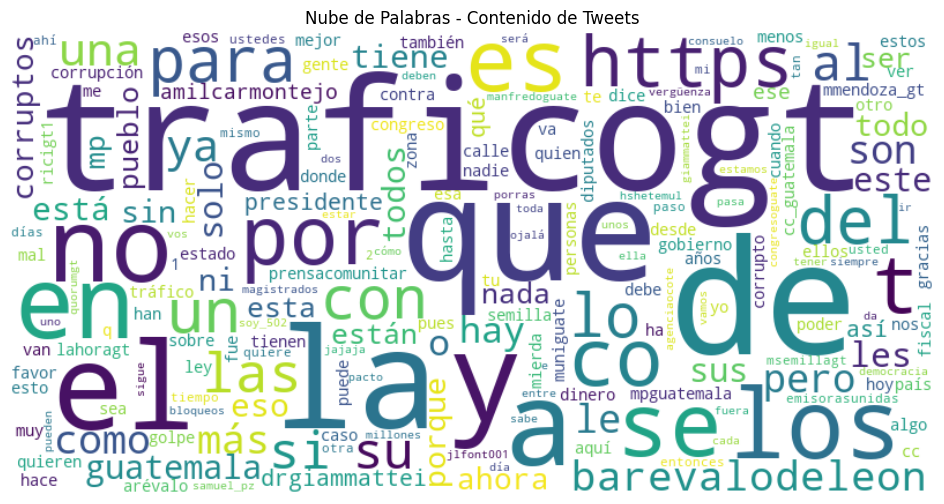

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import re

# Configuración de visualización
plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline

# Cargar los datos
messages = pd.read_csv('traficogt_messages.csv')
df_users = pd.read_csv('usuarios.csv')  # Asumiendo que se guardó con este nombre
df_interactions = pd.read_csv('traficogt_interactions_clean.csv')

# Función para valores únicos y nulos
def basic_info(df, name):
    print(f"=== INFORMACIÓN BÁSICA: {name} ===")
    print(f"Dimensiones: {df.shape[0]} filas, {df.shape[1]} columnas")
    print(f"\nValores nulos por columna:")
    print(df.isnull().sum())
    print(f"\nTipos de datos:")
    print(df.dtypes)
    print("\n" + "="*50)

# Función para análisis de texto
def analyze_text_column(df, column_name, title):
    print(f"\n=== ANÁLISIS DE TEXTO: {title} ===")
    
    # Longitud promedio del texto
    df['text_length'] = df[column_name].astype(str).apply(len)
    print(f"Longitud promedio del texto: {df['text_length'].mean():.2f} caracteres")
    
    # Conteo de palabras
    df['word_count'] = df[column_name].astype(str).apply(lambda x: len(x.split()))
    print(f"Promedio de palabras: {df['word_count'].mean():.2f}")
    
    # Palabras más comunes
    all_text = ' '.join(df[column_name].astype(str).dropna())
    words = re.findall(r'\b\w+\b', all_text.lower())
    word_freq = Counter(words)
    print(f"Palabras más comunes: {word_freq.most_common(10)}")
    
    return word_freq

# 1. ANÁLISIS DE MENSAJES (TWEETS)
basic_info(messages, "MENSAJES")

print("\n=== ESTADÍSTICAS DE MENSAJES ===")
print(f"Total de tweets: {len(messages)}")
print(f"Rango de fechas: {messages['date'].min()} to {messages['date'].max()}")
print(f"Idiomas principales: {messages['lang'].value_counts().head(5).to_dict()}")

# Análisis de interacciones en tweets
print(f"\n=== INTERACCIONES EN TWEETS ===")
print(f"Promedio de likes: {messages['likeCount'].mean():.2f}")
print(f"Promedio de retweets: {messages['retweetCount'].mean():.2f}")
print(f"Promedio de respuestas: {messages['replyCount'].mean():.2f}")
print(f"Promedio de vistas: {messages['viewCount'].mean():.2f}")

# Tweets más populares
top_tweets = messages.nlargest(5, 'likeCount')[['id', 'rawContent', 'likeCount', 'retweetCount']]
print("\nTweets más populares (por likes):")
for i, row in top_tweets.iterrows():
    print(f"  {row['likeCount']} likes: {row['rawContent'][:100]}...")

# Análisis de hashtags
hashtags_all = ' '.join(messages['hashtags'].dropna().astype(str))
hashtag_freq = Counter(re.findall(r'\b\w+\b', hashtags_all.lower()))
print(f"\nHashtags más comunes: {hashtag_freq.most_common(10)}")

# Nube de palabras del contenido
word_freq_messages = analyze_text_column(messages, 'rawContent', 'Contenido de Tweets')
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq_messages)
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de Palabras - Contenido de Tweets')
plt.show()

## Análisis de los usuarios

=== INFORMACIÓN BÁSICA: USUARIOS ===
Dimensiones: 2071 filas, 16 columnas

Valores nulos por columna:
user                        0
user_id                     0
user_displayname            0
user_rawDescription       917
user_created                0
user_followersCount         0
user_favouritesCount        0
user_listedCount            0
user_mediaCount             0
user_location            1040
user_protected              0
user_verified               0
user_blue                   0
user_blueType            2059
user_descriptionLinks       0
user_pinnedIds           1648
dtype: int64

Tipos de datos:
user                      object
user_id                    int64
user_displayname          object
user_rawDescription       object
user_created              object
user_followersCount        int64
user_favouritesCount       int64
user_listedCount           int64
user_mediaCount            int64
user_location             object
user_protected              bool
user_verified            

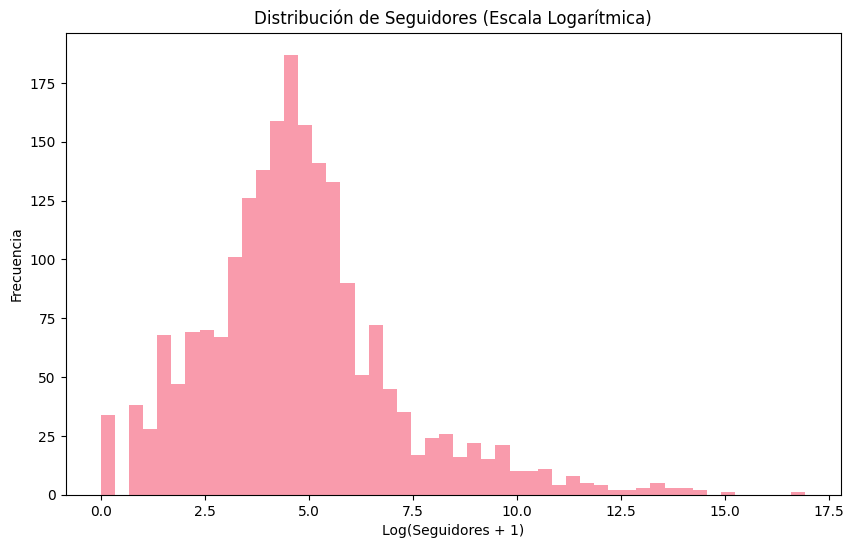

In [21]:
basic_info(df_users, "USUARIOS")

print("\n=== ESTADÍSTICAS DE USUARIOS ===")
print(f"Usuarios únicos: {len(df_users)}")
print(f"Usuarios verificados: {df_users['user_verified'].sum()}")

# Estadísticas de seguidores
print(f"\n=== ESTADÍSTICAS DE SEGUIDORES ===")
print(f"Máximo seguidores: {df_users['user_followersCount'].max()}")
print(f"Mínimo seguidores: {df_users['user_followersCount'].min()}")
print(f"Promedio seguidores: {df_users['user_followersCount'].mean():.2f}")
print(f"Mediana seguidores: {df_users['user_followersCount'].median()}")

# Top usuarios por seguidores
top_users = df_users.nlargest(10, 'user_followersCount')[['user', 'user_displayname', 'user_followersCount']]
print("\nTop 10 usuarios por seguidores:")
print(top_users.to_string(index=False))

# Distribución de seguidores (log scale para mejor visualización)
plt.figure(figsize=(10, 6))
plt.hist(np.log1p(df_users['user_followersCount']), bins=50, alpha=0.7)
plt.xlabel('Log(Seguidores + 1)')
plt.ylabel('Frecuencia')
plt.title('Distribución de Seguidores (Escala Logarítmica)')
plt.show()

## Análisis de las relaciones

=== INFORMACIÓN BÁSICA: INTERACCIONES ===
Dimensiones: 15523 filas, 5 columnas

Valores nulos por columna:
source_user         0
source_user_id      0
target_user         0
interaction_type    0
tweet_id            0
dtype: int64

Tipos de datos:
source_user         object
source_user_id       int64
target_user         object
interaction_type    object
tweet_id             int64
dtype: object


=== ESTADÍSTICAS DE INTERACCIONES ===
Total de interacciones: 15523
Tipos de interacción: {'mention': 10854, 'reply': 4076, 'quote': 593}

Top 10 usuarios más activos:
source_user
traficogt          698
batallonjalapa     455
mildred_gaitan     384
angeln8            197
chofito63569841    166
alejandro2024gt    165
cubreserva         151
iovittor           139
hellboy17oc        129
papaabumario       105
Name: count, dtype: int64

Top 10 usuarios más mencionados:
target_user
traficogt          5622
barevalodeleon      474
prensacomunitar     322
lahoragt            309
amilcarmontejo      224


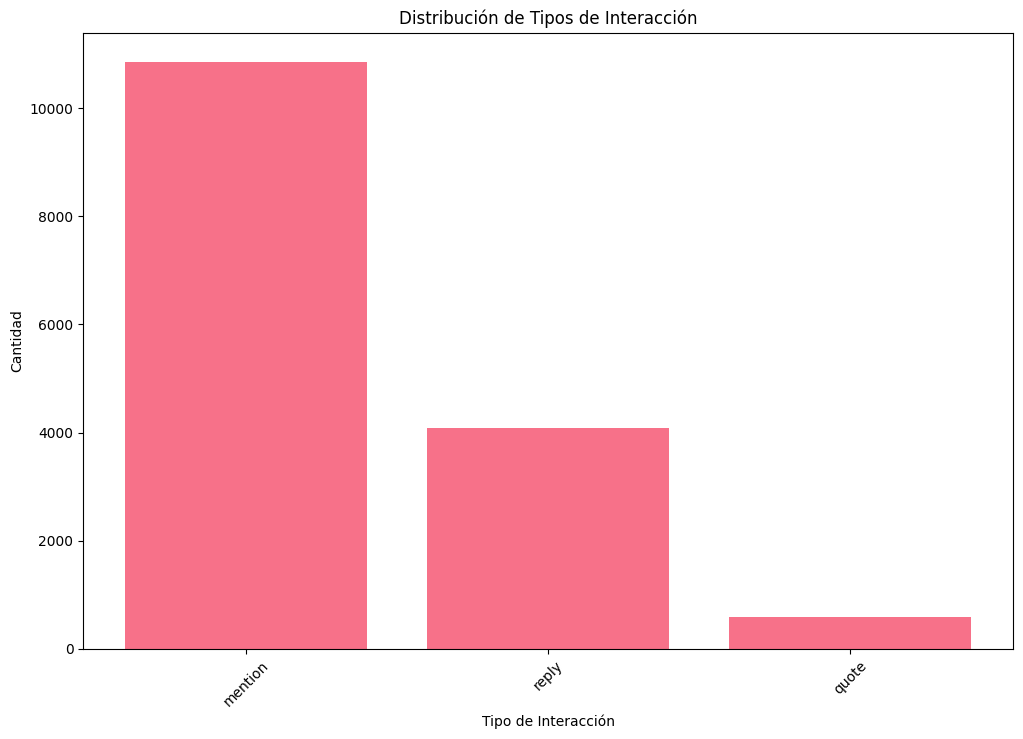

In [22]:
basic_info(df_interactions, "INTERACCIONES")

print("\n=== ESTADÍSTICAS DE INTERACCIONES ===")
print(f"Total de interacciones: {len(df_interactions)}")
print(f"Tipos de interacción: {df_interactions['interaction_type'].value_counts().to_dict()}")

# Usuarios más activos
top_sources = df_interactions['source_user'].value_counts().head(10)
print(f"\nTop 10 usuarios más activos:")
print(top_sources)

# Usuarios más mencionados
top_targets = df_interactions['target_user'].value_counts().head(10)
print(f"\nTop 10 usuarios más mencionados:")
print(top_targets)

# Matriz de interacciones por tipo
interaction_matrix = pd.crosstab(df_interactions['source_user'], df_interactions['interaction_type'])
print(f"\nInteracciones por tipo:")
print(interaction_matrix.sum())

# Grafo de interacciones
plt.figure(figsize=(12, 8))
interaction_counts = df_interactions['interaction_type'].value_counts()
plt.bar(interaction_counts.index, interaction_counts.values)
plt.title('Distribución de Tipos de Interacción')
plt.xlabel('Tipo de Interacción')
plt.ylabel('Cantidad')
plt.xticks(rotation=45)
plt.show()

Habiendo obtenido información sobre los sets de datos que tenemo, vemos que hay información interesante tanto en los mensajes, usuarios y también en las relaciones. Pero además de distribuciones y conteos también es posible analizar más información dentre de los datos. Este análisis inicial nos da una idea general de los datos y sus distribuciones, pero al ver los datos nos hemos preugntado lo siguiente:

* ¿Cuáles son las horas pico de actividad en Twitter para hablar sobre el tráfico?
* ¿Cuales son los hashtags más populares?
* ¿Cuales son los usuarios con mas seguidores?
* ¿Cuantos usuarios están verificados vs cuantos están con blue (check azul)?




1. ¿Cuáles son las horas pico de actividad en Twitter?


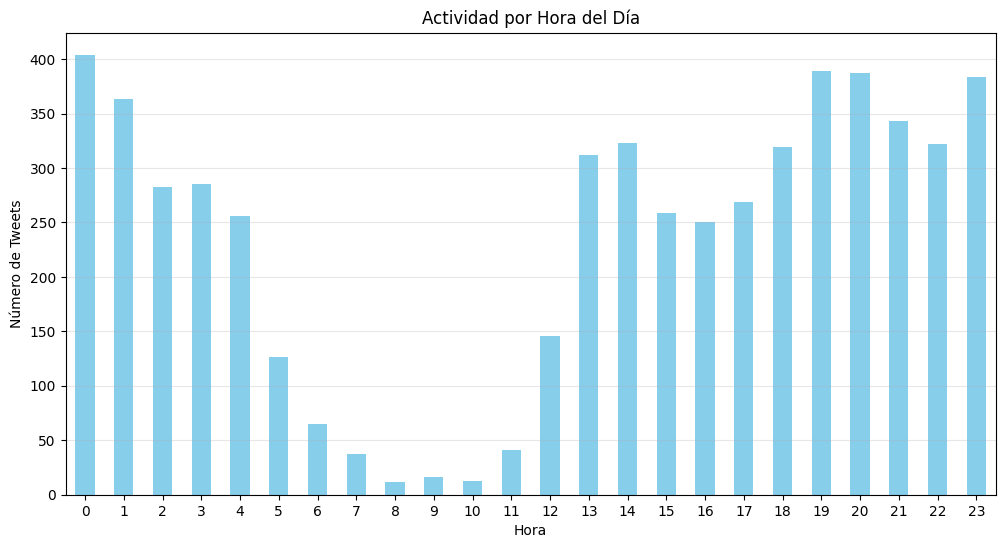

Horas con mayor actividad: {0: np.int64(404), 19: np.int64(389), 20: np.int64(387)}


In [23]:
# 4. PREGUNTAS INTERESANTES Y RESPUESTAS

# Pregunta 1: ¿Cuáles son las horas pico de actividad en Twitter?
print("\n1. ¿Cuáles son las horas pico de actividad en Twitter?")
messages['datetime'] = pd.to_datetime(messages['date'])
messages['hour'] = messages['datetime'].dt.hour
hourly_activity = messages['hour'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
hourly_activity.plot(kind='bar', color='skyblue')
plt.title('Actividad por Hora del Día')
plt.xlabel('Hora')
plt.ylabel('Número de Tweets')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.show()

print(f"Horas con mayor actividad: {dict(hourly_activity.nlargest(3))}")



Curiosamente dentro de los tweets se ve que la mayor parte del tiempo hay grandes cantidades de tweets a lo largo del día excepto de las 5am a las 12. Esto llama la atención ya que incluso en horas de la madrugada como de las 0 a las 4 horas hay bastantes más interacciones. De igual manera de en la tarde y altas horas de la noche es que hay varios tweets. Seguramente esto se deba a que la mayoría de personas entre las 5 y 12 se encontarán o bien en el trabajo o estudiando. Esta métrica es interesante ya que podría apoyar a personas a elegir en que momentos realmente es el más oportuno para poder hacer una publicación para que alcance a lamyor cantidad de presonas. parece haerb más actividad especialmente en 18, 19, 23 y 0 horas.


2. ¿Cuáles son los hashtags más populares?
Top 15 hashtags más populares:
  #ahora: 30 menciones
  #guatemala: 25 menciones
  #ahoralh: 19 menciones
  #urgente: 16 menciones
  #traficogt: 16 menciones
  #renunciengolpistas: 15 menciones
  #paronacionalindefinido: 9 menciones
  #lahoradeactualizarnos: 8 menciones
  #guateresiste: 8 menciones
  #paronacionaindefinido: 8 menciones
  #lhnacionales: 7 menciones
  #lhenbreve: 7 menciones
  #adiosconsuelo: 7 menciones
  #tráfico: 7 menciones
  #consueloporras: 6 menciones


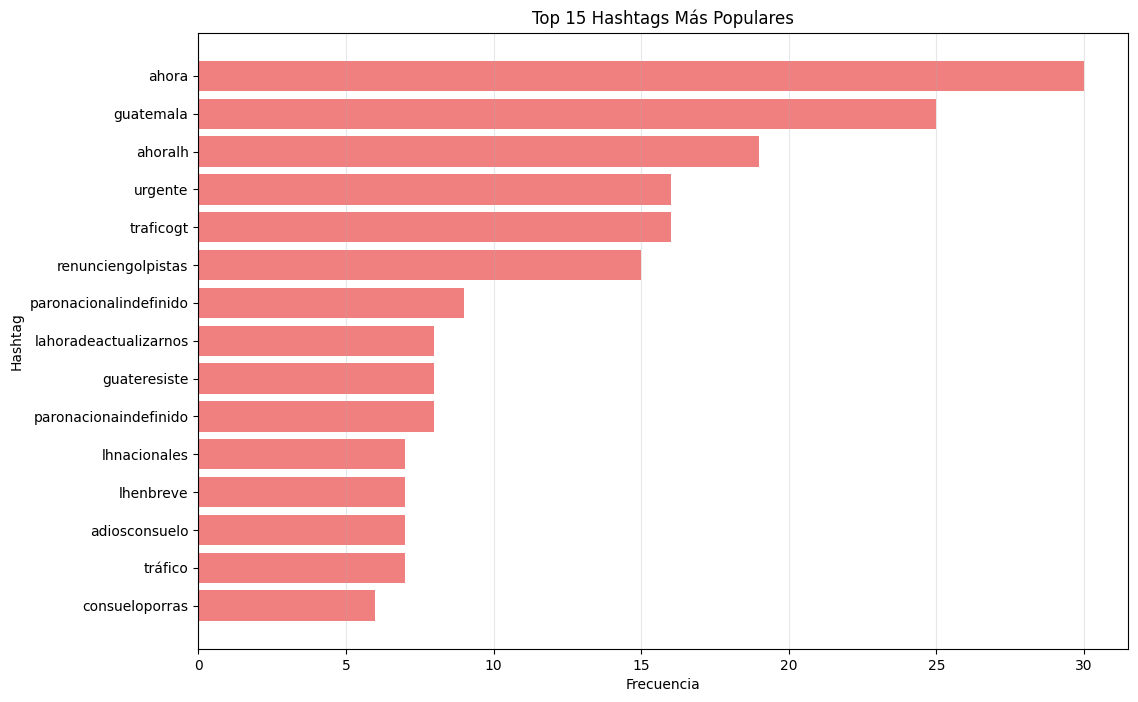


Análisis de engagement por hashtag:

Top 10 hashtags por engagement promedio:
  #nuevocongreso: 16086.00 engagement promedio
  #bloqueossemilla: 7227.00 engagement promedio
  #paronacionaiindefinido: 6772.00 engagement promedio
  #cambiodemando: 4557.00 engagement promedio
  #euprocesodetransición: 3524.00 engagement promedio
  #videolh: 3330.00 engagement promedio
  #estadodederecho: 2958.00 engagement promedio
  #guatedecide: 2693.00 engagement promedio
  #capital: 2693.00 engagement promedio
  #altaverapaz: 2693.00 engagement promedio


In [24]:
# Pregunta 2: ¿Cuáles son los hashtags más populares?
print("\n2. ¿Cuáles son los hashtags más populares?")

# Extraer y analizar hashtags
def extract_hashtags(text):
    if pd.isna(text) or text == 'NA':
        return []
    return re.findall(r'#(\w+)', str(text).lower())

# Extraer todos los hashtags
all_hashtags = []
for hashtags_str in messages['hashtags']:
    if pd.notna(hashtags_str) and hashtags_str != 'NA':
        hashtags_list = str(hashtags_str).split(',')
        all_hashtags.extend([tag.strip().lower() for tag in hashtags_list if tag.strip()])

hashtag_freq = Counter(all_hashtags)
top_hashtags = hashtag_freq.most_common(15)

print("Top 15 hashtags más populares:")
for hashtag, count in top_hashtags:
    print(f"  #{hashtag}: {count} menciones")

# Visualización de hashtags
plt.figure(figsize=(12, 8))
hashtags_df = pd.DataFrame(top_hashtags, columns=['Hashtag', 'Frecuencia'])
plt.barh(hashtags_df['Hashtag'], hashtags_df['Frecuencia'], color='lightcoral')
plt.xlabel('Frecuencia')
plt.ylabel('Hashtag')
plt.title('Top 15 Hashtags Más Populares')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.show()

# Análisis de engagement por hashtag
print("\nAnálisis de engagement por hashtag:")
hashtag_engagement = {}
for index, row in messages.iterrows():
    if pd.notna(row['hashtags']) and row['hashtags'] != 'NA':
        engagement = row['likeCount'] + row['retweetCount'] + row['replyCount']
        hashtags = str(row['hashtags']).split(',')
        for tag in hashtags:
            tag = tag.strip().lower()
            if tag:
                if tag not in hashtag_engagement:
                    hashtag_engagement[tag] = []
                hashtag_engagement[tag].append(engagement)

# Calcular engagement promedio por hashtag
avg_engagement = {tag: np.mean(engagements) for tag, engagements in hashtag_engagement.items()}
top_engagement_hashtags = sorted(avg_engagement.items(), key=lambda x: x[1], reverse=True)[:10]

print("\nTop 10 hashtags por engagement promedio:")
for hashtag, avg_eng in top_engagement_hashtags:
    print(f"  #{hashtag}: {avg_eng:.2f} engagement promedio")

Si evaluamos específcicamente por la cantidad de uso del hashtag se puede ver que realmente hay bastante variedad en los temas. El hashtag más común en este sentido es #ahora. Seguramente sea porque todos los tweets están relacionados de una forma u otra con el tráfico y eventos recientes. De lo que sabemos, ese hashtag se usa para noticias recientes y para que las personas tengan un hashtag para ver lo último que está pasando. Luego le siguen hastags relacionados al país y de igual manera relacionados a noticias: #Guatemala, horalh, traficogt, etc. Lo interesante es que también hay distintos hashtags que hacen referencia a renuncias y el apro nacional. Esto tiene sentido si recordamos eventos recientes donde hubieron manifestaciones, paros, y demás situaciones que empeorarón el tráfico e incluso detuvieron actividades en el país. Los conteos pueden verse bajos

Ahora si analizamos el engagement promedio vemos que los hastags cambian un poco, siguen habiendo relacionados bloqueos y el paro nacional, junto con otros temas relacionados pero realmente es más sobre temas políticos en este caso. Viendo esto podemos comenzar a hacer la asociación que el tráfico puede que se vea afectado en gran manera con eventos políticos y huelgas por culpa de la inconformiadad del puelbo guatemalteco.


3. ¿Cuáles son los usuarios con más seguidores dentro del set de datos?
Top 15 usuarios por número de seguidores:
  1477. cnnee (cnn en español) 
      Seguidores: 22,578,187
  1267. patriciajaniot (patricia janiot) 
      Seguidores: 2,990,852
  45. prensa_libre (prensa libre) 
      Seguidores: 1,685,961
  460. emisorasunidas (emisoras unidas) 
      Seguidores: 1,583,157
  463. dw_espanol (dw español) 
      Seguidores: 1,441,832
  515. soy_502 (soy 502) 
      Seguidores: 1,258,178
  943. guatevision_tv (guatevisión) 
      Seguidores: 1,222,148
  1384. el_periodico (elperiódico) 
      Seguidores: 955,543
  1109. pikaso_me (pikaso) 
      Seguidores: 887,804
  1050. amilcarmontejo (amilcar montejo) 
      Seguidores: 856,742
  1418. threadreaderapp (thread reader app) 
      Seguidores: 763,397
  1908. muniguate (muniguate) 
      Seguidores: 748,587
  689. canalantigua (canal antigua) 
      Seguidores: 593,900
  599. renasuspendido (el renacido) 
      Seguidores: 560,586
  37.

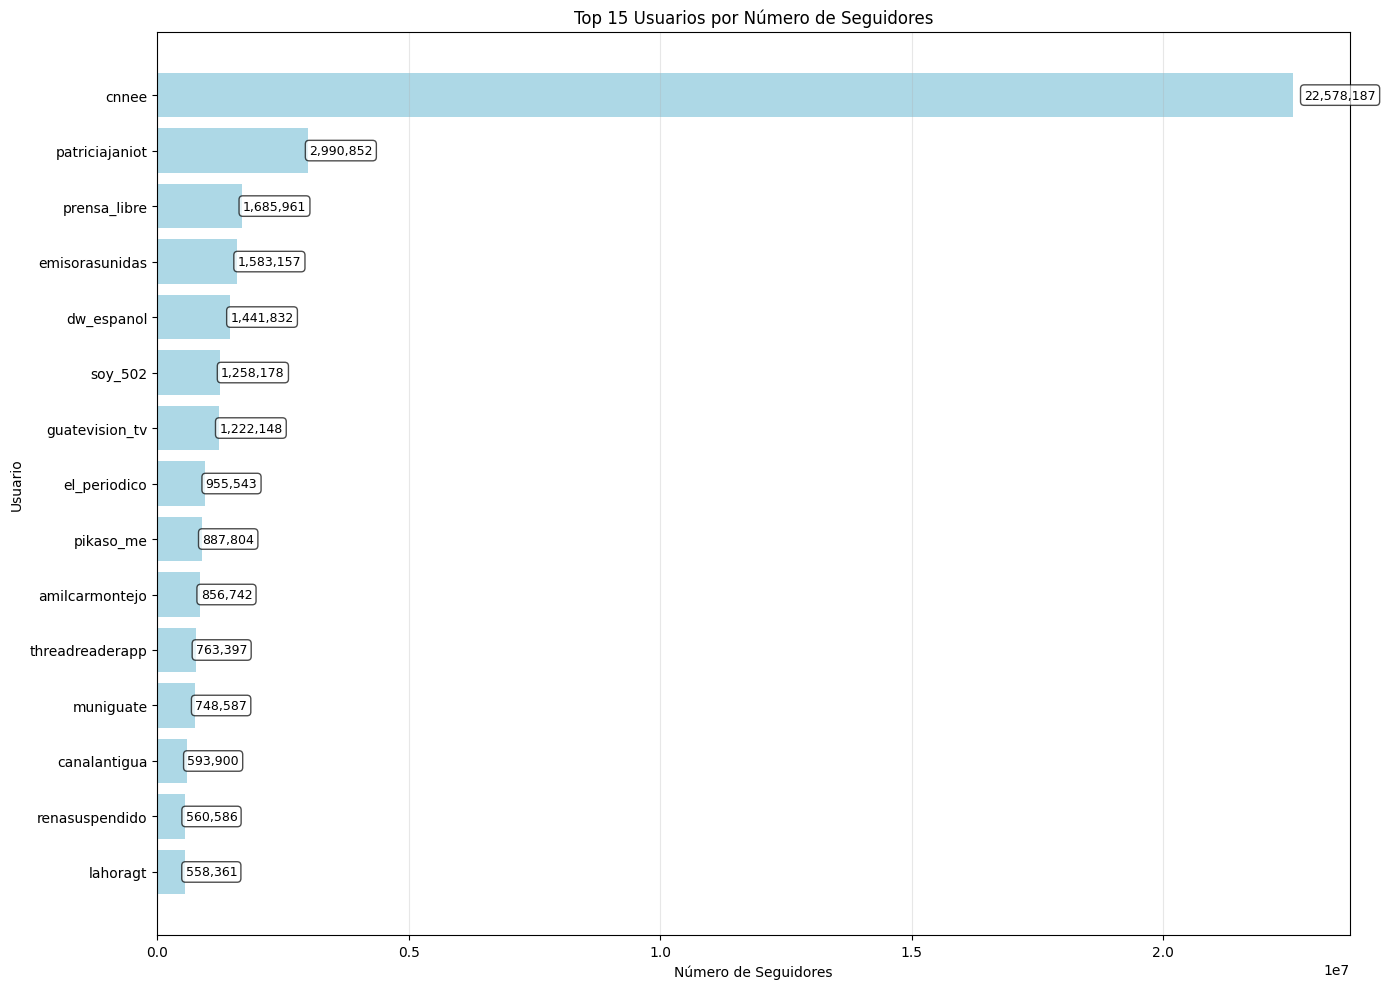

In [25]:
# Pregunta 3: ¿Cuáles son los usuarios con más seguidores dentro del set de datos?
print("\n3. ¿Cuáles son los usuarios con más seguidores dentro del set de datos?")

# Top 15 usuarios por seguidores
top_followers = df_users.nlargest(15, 'user_followersCount')[['user', 'user_displayname', 'user_followersCount', 'user_verified']]
print("Top 15 usuarios por número de seguidores:")
for i, row in top_followers.iterrows():
    verification = "✓" if row['user_verified'] else ""
    print(f"  {i+1:2d}. {row['user']} ({row['user_displayname']}) {verification}")
    print(f"      Seguidores: {row['user_followersCount']:,}")

# Visualización de top usuarios por seguidores
plt.figure(figsize=(14, 10))
plt.barh(top_followers['user'], top_followers['user_followersCount'], 
         color=['gold' if verified else 'lightblue' for verified in top_followers['user_verified']])
plt.xlabel('Número de Seguidores')
plt.ylabel('Usuario')
plt.title('Top 15 Usuarios por Número de Seguidores')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)

# Agregar valores en las barras
for i, (value, verified) in enumerate(zip(top_followers['user_followersCount'], top_followers['user_verified'])):
    plt.text(value + value * 0.01, i, f'{value:,}', va='center', fontsize=9,
             bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.3'))

plt.tight_layout()
plt.show()

En esta gráfica realmente no encontramos algún insight tan relevante con respecto al tráfico, todos los usuarios con más eguidores son empresas o noticieros relacionados al periodismo y noticias. tal vez el más destacado sería patriciajianot. Investigando encontramos que es una periodista colombiana, pero que eventtualmente ahce comentarios sobre eventos políticos y noticias importantes dentro del país. En el caso de cnnee, es la cuenta de CNN en español.


4. ¿Cuántas personas están verificadas y cuántas tienen cuenta azul?

Estadísticas de verificación:
  Usuarios verificados: 0
  Usuarios no verificados: 2071
  Porcentaje de verificados: 0.00%

Estadísticas de cuenta azul:
  Usuarios con cuenta azul: 92
  Usuarios sin cuenta azul: 1979
  Porcentaje con cuenta azul: 4.44%

Usuarios con verificación Y cuenta azul: 0
Porcentaje con ambas: 0.00%


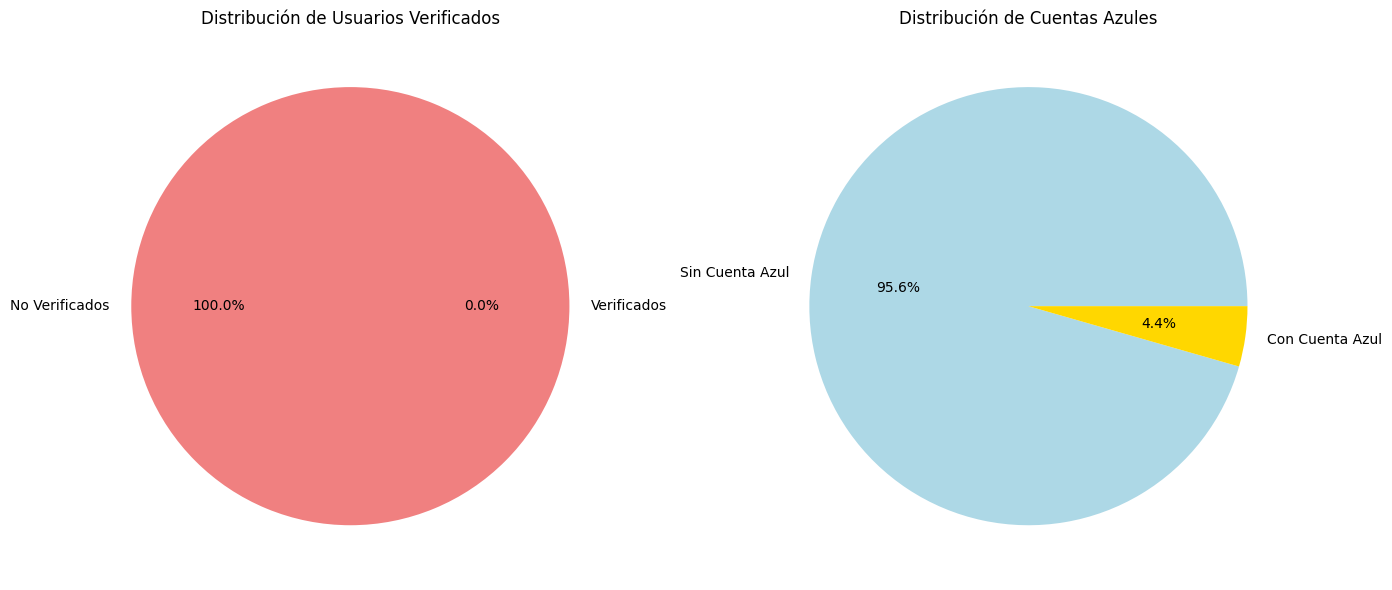


Análisis de seguidores por tipo de cuenta:
  Promedio seguidores - Verificados: nan
  Promedio seguidores - No verificados: 22052.98
  Promedio seguidores - Cuenta azul: 432099.52
  Promedio seguidores - Sin cuenta azul: 2990.69


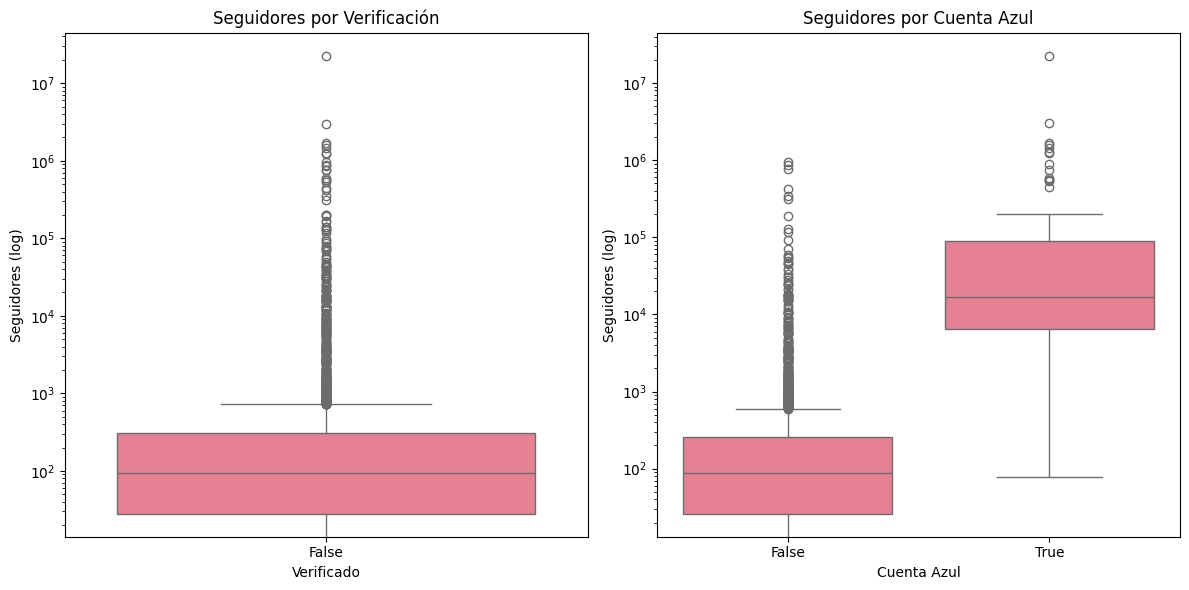

In [26]:
# Pregunta 4: ¿Cuántas personas están verificadas y cuántas tienen cuenta azul?
print("\n4. ¿Cuántas personas están verificadas y cuántas tienen cuenta azul?")

# Estadísticas de verificación
verified_stats = df_users['user_verified'].value_counts()
blue_stats = df_users['user_blue'].value_counts()

print(f"\nEstadísticas de verificación:")
print(f"  Usuarios verificados: {verified_stats.get(True, 0)}")
print(f"  Usuarios no verificados: {verified_stats.get(False, 0)}")
print(f"  Porcentaje de verificados: {verified_stats.get(True, 0)/len(df_users)*100:.2f}%")

print(f"\nEstadísticas de cuenta azul:")
print(f"  Usuarios con cuenta azul: {blue_stats.get(True, 0)}")
print(f"  Usuarios sin cuenta azul: {blue_stats.get(False, 0)}")
print(f"  Porcentaje con cuenta azul: {blue_stats.get(True, 0)/len(df_users)*100:.2f}%")

# Usuarios que tienen ambas características
both_verified_and_blue = len(df_users[(df_users['user_verified'] == True) & (df_users['user_blue'] == True)])
print(f"\nUsuarios con verificación Y cuenta azul: {both_verified_and_blue}")
print(f"Porcentaje con ambas: {both_verified_and_blue/len(df_users)*100:.2f}%")

# Visualización
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Gráfico de verificación
verified_labels = ['No Verificados', 'Verificados']
verified_values = [verified_stats.get(False, 0), verified_stats.get(True, 0)]
ax1.pie(verified_values, labels=verified_labels, autopct='%1.1f%%', colors=['lightcoral', 'lightgreen'])
ax1.set_title('Distribución de Usuarios Verificados')

# Gráfico de cuenta azul
blue_labels = ['Sin Cuenta Azul', 'Con Cuenta Azul']
blue_values = [blue_stats.get(False, 0), blue_stats.get(True, 0)]
ax2.pie(blue_values, labels=blue_labels, autopct='%1.1f%%', colors=['lightblue', 'gold'])
ax2.set_title('Distribución de Cuentas Azules')

plt.tight_layout()
plt.show()

# Análisis de seguidores por tipo de cuenta
print(f"\nAnálisis de seguidores por tipo de cuenta:")
print(f"  Promedio seguidores - Verificados: {df_users[df_users['user_verified']]['user_followersCount'].mean():.2f}")
print(f"  Promedio seguidores - No verificados: {df_users[~df_users['user_verified']]['user_followersCount'].mean():.2f}")
print(f"  Promedio seguidores - Cuenta azul: {df_users[df_users['user_blue']]['user_followersCount'].mean():.2f}")
print(f"  Promedio seguidores - Sin cuenta azul: {df_users[~df_users['user_blue']]['user_followersCount'].mean():.2f}")

# Boxplot comparativo
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x='user_verified', y='user_followersCount', data=df_users)
plt.yscale('log')
plt.title('Seguidores por Verificación')
plt.xlabel('Verificado')
plt.ylabel('Seguidores (log)')

plt.subplot(1, 2, 2)
sns.boxplot(x='user_blue', y='user_followersCount', data=df_users)
plt.yscale('log')
plt.title('Seguidores por Cuenta Azul')
plt.xlabel('Cuenta Azul')
plt.ylabel('Seguidores (log)')

plt.tight_layout()
plt.show()

Aquí encontramos algo interesante dentro del set de datos. Evaluando la cantidad de personas verificadas con las personas con el "blue", vemos que realmente no hay personas verificadas. Dentro del análisis se destaca que realmente casi todos (o todos) tienen un valor vacío. Esto puede ser por 2 motivos, primero puede ser un error al momento de transformar los datos aunque es poco probable ya que la columna de Blue si tiene valores válidos. Entonces seguramente por el cambio que se hizo de twitter a X, la API o la forma en la que se obtuvieron los datos reconoce a los usuarios verificados ahora solo como Blue y es por eso que se tiene también la columna tipo de Blue. Teniendo esto en mente es importante dejar del la columna de verificado y enfocarse en la de user_blue. 

En el caso de las personas con blue se puede ver que en promedio se tienen bastantes más seguidore, esto tiene sentido si tomamos en cuenta que esta es la nueva forma de identificar las personas verificadas. En total se tiene un promedio de 420k seguidores para las cuentas con blue. Mientras que el promedio para las cuetnas que no lo tienen es de 2k aproximadamente. Eso sí, como se puede ver en ambos casos, hay varios casos atípicos que se salen del promedio a pesar de no estar verificados/con blue. Hay cuentas que parecen tener tantos seguidores como cuentas blue.

# Análisis de la red

In [27]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import Counter

# Cargar las interacciones
df_interactions = pd.read_csv('traficogt_interactions_clean.csv')

# Crear grafo dirigido
G = nx.DiGraph()

# Agregar nodos y aristas desde las interacciones
for _, row in df_interactions.iterrows():
    source = row['source_user']
    target = row['target_user']
    interaction_type = row['interaction_type']
    
    # Agregar nodos si no existen
    if not G.has_node(source):
        G.add_node(source)
    if not G.has_node(target):
        G.add_node(target)
    
    # Agregar arista o incrementar peso si ya existe
    if G.has_edge(source, target):
        G[source][target]['weight'] += 1
        G[source][target]['types'].add(interaction_type)
    else:
        G.add_edge(source, target, weight=1, types={interaction_type})

print(" INFORMACIÓN BÁSICA DEL GRAFO \n ")
print(f"Número de nodos: {G.number_of_nodes()}")
print(f"Número de aristas: {G.number_of_edges()}")
print(f"Es dirigido: {nx.is_directed(G)}")

# Calcular grados de los nodos
in_degrees = dict(G.in_degree())
out_degrees = dict(G.out_degree())
total_degrees = dict(G.degree())

# Nodos más conectados
top_in_degree = sorted(in_degrees.items(), key=lambda x: x[1], reverse=True)[:10]
top_out_degree = sorted(out_degrees.items(), key=lambda x: x[1], reverse=True)[:10]
top_total_degree = sorted(total_degrees.items(), key=lambda x: x[1], reverse=True)[:10]

 INFORMACIÓN BÁSICA DEL GRAFO 
 
Número de nodos: 2743
Número de aristas: 7520
Es dirigido: True


In [28]:
print("\nTop 10 nodos por grado de entrada (más mencionados):")
for user, degree in top_in_degree:
    print(f"  {user}: {degree} menciones recibidas")

print("\nTop 10 nodos por grado de salida (más activos):")
for user, degree in top_out_degree:
    print(f"  {user}: {degree} interacciones enviadas")

print("\nTop 10 nodos por grado total:")
for user, degree in top_total_degree:
    print(f"  {user}: {degree} conexiones totales")


Top 10 nodos por grado de entrada (más mencionados):
  traficogt: 1891 menciones recibidas
  barevalodeleon: 327 menciones recibidas
  drgiammattei: 132 menciones recibidas
  prensacomunitar: 123 menciones recibidas
  mmendoza_gt: 110 menciones recibidas
  mpguatemala: 103 menciones recibidas
  lahoragt: 91 menciones recibidas
  amilcarmontejo: 90 menciones recibidas
  cc_guatemala: 81 menciones recibidas
  muniguate: 66 menciones recibidas

Top 10 nodos por grado de salida (más activos):
  traficogt: 191 interacciones enviadas
  mildred_gaitan: 112 interacciones enviadas
  batallonjalapa: 109 interacciones enviadas
  chofito63569841: 59 interacciones enviadas
  cubreserva: 44 interacciones enviadas
  giovanottigt: 41 interacciones enviadas
  erwin15: 37 interacciones enviadas
  mariacdeleon1: 33 interacciones enviadas
  hellboy17oc: 32 interacciones enviadas
  erosan3edsa: 32 interacciones enviadas

Top 10 nodos por grado total:
  traficogt: 2082 conexiones totales
  barevalodeleon: 

# Analisis de características de la red

In [29]:
# 1. DENSIDAD DE LA RED
n_nodes = G.number_of_nodes()
n_edges = G.number_of_edges()
max_possible_edges = n_nodes * (n_nodes - 1)  # Para grafo dirigido
density = nx.density(G)

print(f"\n1. DENSIDAD DE LA RED:")
print(f"    Número de nodos: {n_nodes}")
print(f"    Número de aristas: {n_edges}")
print(f"    Máximo posible de aristas: {max_possible_edges}")
print(f"    Densidad: {density:.6f} ({density*100:.4f}%)")
print(f"    Interpretación: La red está {'densamente' if density > 0.1 else 'escasamente'} conectada")

# 2. DIÁMETRO DE LA RED
print(f"\n2. DIÁMETRO DE LA RED:")

# Verificar conectividad
if nx.is_weakly_connected(G):
    # Para grafo dirigido, usamos la versión no dirigida para el diámetro
    G_undirected = G.to_undirected()
    diameter = nx.diameter(G_undirected)
    avg_path_length = nx.average_shortest_path_length(G_undirected)
    
    print(f"Diámetro: {diameter}")
    print(f"Longitud promedio de camino: {avg_path_length:.3f}")
    print(f"Máximo {diameter} pasos para conectar cualquier par de usuarios")
else:
    # Si no está débilmente conectado, analizar el componente gigante
    largest_wcc = max(nx.weakly_connected_components(G), key=len)
    G_largest = G.subgraph(largest_wcc)
    G_largest_undirected = G_largest.to_undirected()
    
    diameter = nx.diameter(G_largest_undirected)
    avg_path_length = nx.average_shortest_path_length(G_largest_undirected)
    
    print(f"La red no está completamente conectada")
    print(f"Componente gigante: {len(largest_wcc)} nodos ({len(largest_wcc)/n_nodes*100:.1f}%)")
    print(f"Diámetro del componente gigante: {diameter}")
    print(f"Longitud promedio de camino: {avg_path_length:.3f}")

# COEFICIENTE DE AGRUPAMIENTO
print(f"\n3. COEFICIENTE DE AGRUPAMIENTO:")

# Para grafo dirigido, se pasa a no dirigido para clustering
G_undirected = G.to_undirected()
avg_clustering = nx.average_clustering(G_undirected)
global_clustering = nx.transitivity(G_undirected)

print(f"Coeficiente promedio de agrupamiento: {avg_clustering:.4f}")
print(f"Coeficiente global de agrupamiento (transitividad): {global_clustering:.4f}")
print(f"Interpretación: {'Alto' if avg_clustering > 0.3 else 'Medio' if avg_clustering > 0.1 else 'Bajo'} grado de formación de clústeres")

# Top 10 usuarios con mayor clustering
clustering_coeffs = nx.clustering(G_undirected)
top_clustering = sorted(clustering_coeffs.items(), key=lambda x: x[1], reverse=True)[:10]
print(f"\n   Top 10 usuarios con mayor clustering:")
for user, coeff in top_clustering:
    if coeff > 0:  # Solo mostrar si tienen clustering
        print(f"     {user}: {coeff:.4f}")


1. DENSIDAD DE LA RED:
    Número de nodos: 2743
    Número de aristas: 7520
    Máximo posible de aristas: 7521306
    Densidad: 0.001000 (0.1000%)
    Interpretación: La red está escasamente conectada

2. DIÁMETRO DE LA RED:
Diámetro: 4
Longitud promedio de camino: 2.477
Máximo 4 pasos para conectar cualquier par de usuarios

3. COEFICIENTE DE AGRUPAMIENTO:
Coeficiente promedio de agrupamiento: 0.3415
Coeficiente global de agrupamiento (transitividad): 0.0063
Interpretación: Alto grado de formación de clústeres

   Top 10 usuarios con mayor clustering:
     partidoune: 1.0000
     arkmazariegos: 1.0000
     eddyarredondo23: 1.0000
     kiluluki: 1.0000
     erickpinaleshou: 1.0000
     blanki9rodiguez: 1.0000
     florespolo76g: 1.0000
     dsepet: 1.0000
     jaguilar91juan: 1.0000
     gudielarma24032: 1.0000


# Visualización de la red

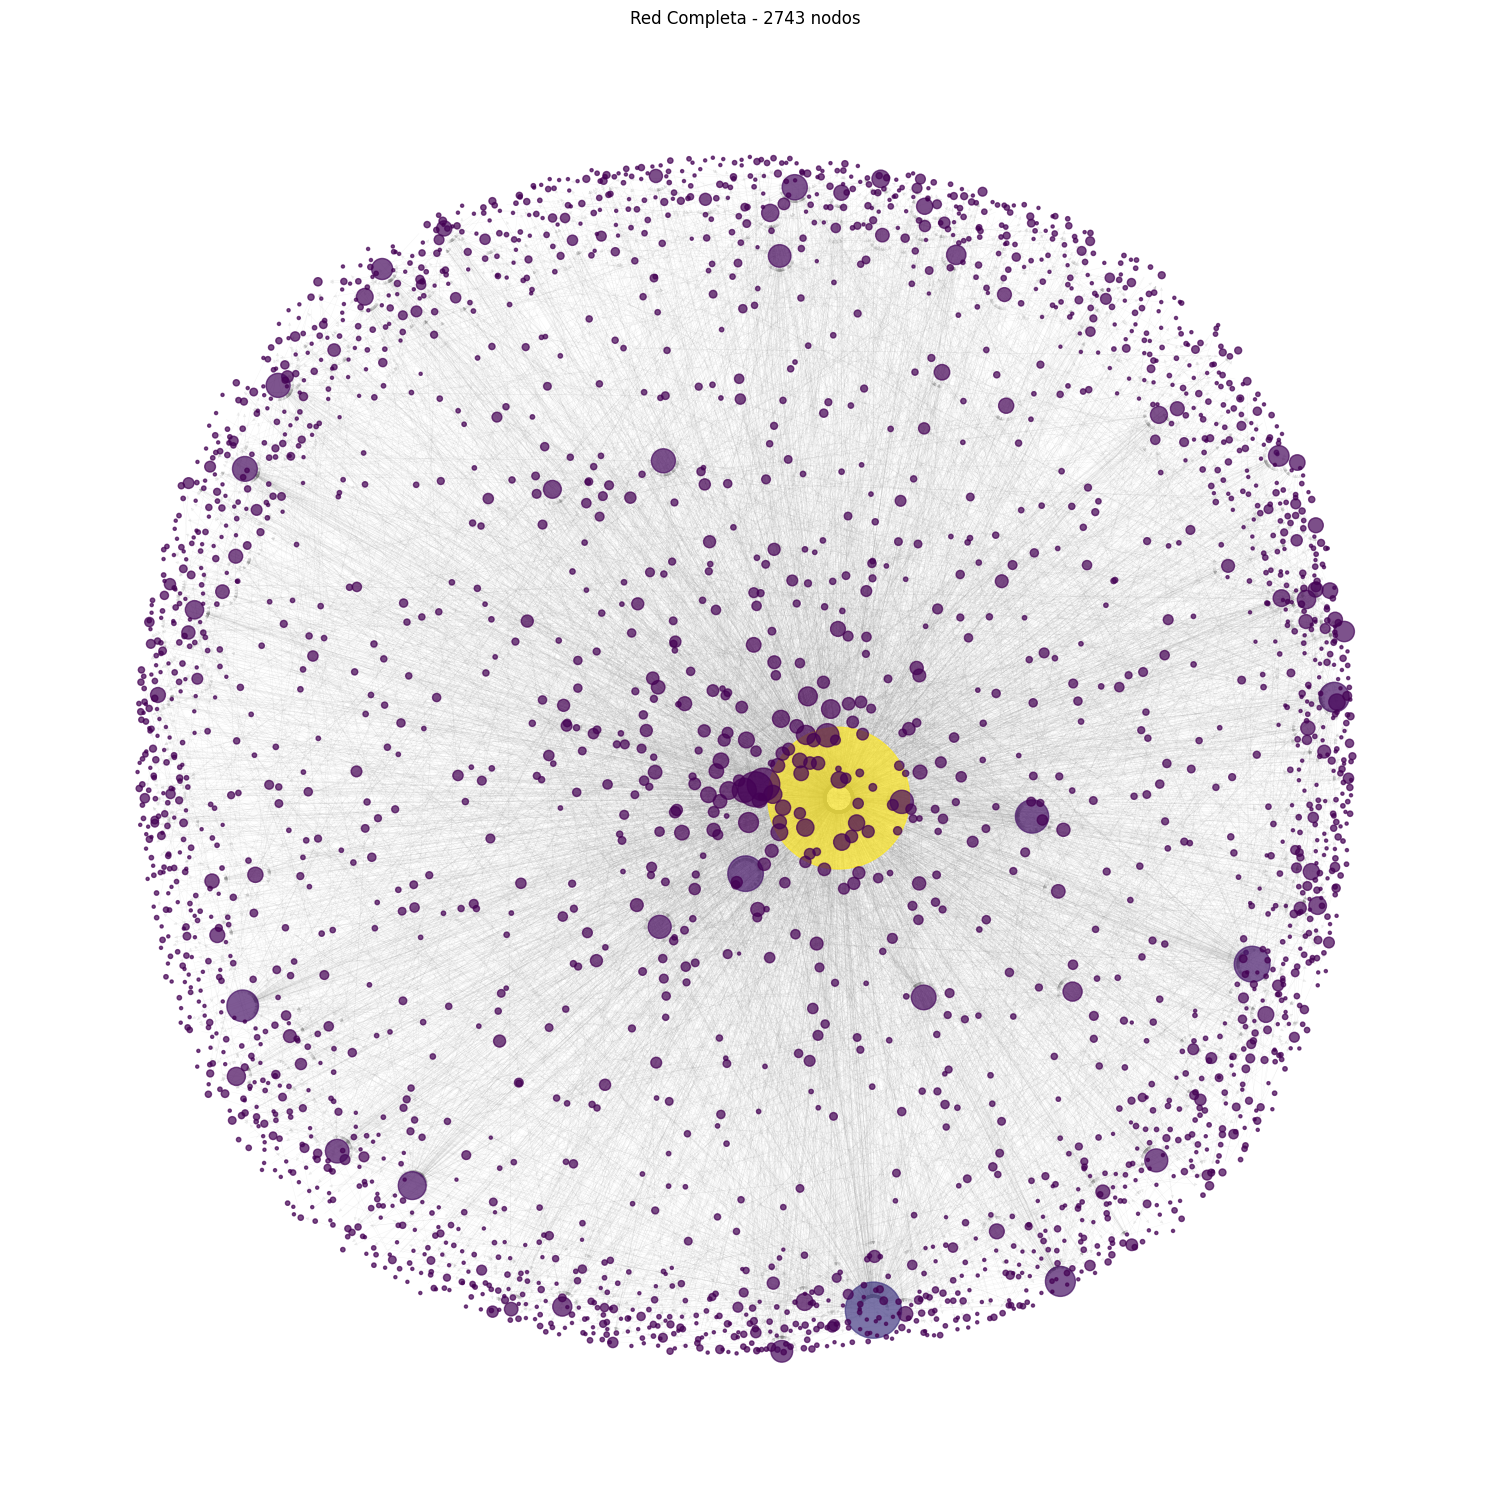

In [30]:
plt.figure(figsize=(15, 15))

# Layout para toda la red
pos = nx.spring_layout(G, k=0.5, iterations=50)  # k controla separación

# Tamaños y colores basados en métricas
node_sizes = [total_degrees[n] * 5 for n in G.nodes()]  # Tamaño por grado total
in_deg_values = [in_degrees[n] for n in G.nodes()]

# Dibujar la red completa
nx.draw_networkx_nodes(G, pos, 
                      node_size=node_sizes,
                      node_color=in_deg_values, 
                      cmap='viridis', 
                      alpha=0.7)

nx.draw_networkx_edges(G, pos, 
                      alpha=0.1,  # Transparencia baja para ver mejor
                      edge_color='gray',
                      arrows=True, 
                      arrowsize=5,
                      width=0.3)

plt.title(f'Red Completa - {G.number_of_nodes()} nodos')
plt.axis('off')
plt.tight_layout()
plt.show()

# Analisis de comunidades

In [31]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import Counter, defaultdict
import community as community_louvain  # pip install python-louvain
from matplotlib.colors import ListedColormap

print("6.1 ALGORITMOS DE DETECCIÓN DE COMUNIDADES\n")

# El algoritmo más usado es LOUVAIN aka modularity optimization
# Para grafos dirigidos, convertimos a no dirigido manteniendo pesos
G_undirected = G.to_undirected()

# Agregar pesos si las aristas no los tienen
for edge in G_undirected.edges():
    if 'weight' not in G_undirected[edge[0]][edge[1]]:
        G_undirected[edge[0]][edge[1]]['weight'] = 1

print("Algoritmo seleccionado: LOUVAIN")

# Aplicar algoritmo de Louvain
partition = community_louvain.best_partition(G_undirected, weight='weight')

# Calcular modularidad
modularity = community_louvain.modularity(partition, G_undirected, weight='weight')

print(f"Comunidades detectadas: {len(set(partition.values()))}")
print(f"Modularidad: {modularity:.4f}")

# Análisis de tamaños de comunidades
community_sizes = Counter(partition.values())
communities_sorted = sorted(community_sizes.items(), key=lambda x: x[1], reverse=True)

print("Distribución de tamaños de comunidades:")
for i, (comm_id, size) in enumerate(communities_sorted[:10]):
    percentage = (size / len(partition)) * 100
    print(f"Comunidad {comm_id}: {size} usuarios ({percentage:.1f}%)")


6.1 ALGORITMOS DE DETECCIÓN DE COMUNIDADES

Algoritmo seleccionado: LOUVAIN
Comunidades detectadas: 45
Modularidad: 0.3817
Distribución de tamaños de comunidades:
Comunidad 0: 918 usuarios (33.5%)
Comunidad 2: 246 usuarios (9.0%)
Comunidad 6: 236 usuarios (8.6%)
Comunidad 3: 231 usuarios (8.4%)
Comunidad 5: 148 usuarios (5.4%)
Comunidad 7: 144 usuarios (5.2%)
Comunidad 9: 129 usuarios (4.7%)
Comunidad 16: 122 usuarios (4.4%)
Comunidad 10: 88 usuarios (3.2%)
Comunidad 1: 83 usuarios (3.0%)


Se convirtió el grafo dirigido a uno no dirigido para que el algoritmo Louvain pueda trabajarlo correctamente. En caso de que algunas aristas no tuvieran peso se les asignó el valor 1.  
Se detectaron 45 comunidades, dinde la modularidad fue de *0.3817* lo que indica una estructura comunitaria moderadamente fuerte.  
La comunidad más grande tiene 918 usuarios, lo que representa un 33.5%, seguida de otras de menor tamaño (aprox 200 y 500), y luego otras más pequeñas.  
Se puede decir que aunque existen bastantes comunidades, la mayor parte de la interacción se concentra en pocas comunidades. En el contexto de las redes sociales esto puede estar relacionado a clusters de usuarios muy conectados y también hay otras comunidades que representan nichos más pequeños.

In [33]:
# ------------------ chunk: communities -> miembros + keywords (con stopwords español) ------------------
import os
import json
import math
import pandas as pd
import networkx as nx
from sklearn.feature_extraction.text import CountVectorizer

# Intentar obtener stopwords en español (NLTK) con fallback a lista embebida
try:
    import nltk
    from nltk.corpus import stopwords
    nltk.download('stopwords', quiet=True)
    spanish_stopwords = stopwords.words('spanish')
    print("Stopwords español cargadas desde NLTK (", len(spanish_stopwords), "palabras ).")
except Exception as e:
    print("No se pudo cargar NLTK stopwords:", str(e))
    # Fallback: lista corta/útil de stopwords en español (ampliable)
    spanish_stopwords = [
        "de","la","que","el","en","y","a","los","del","se","las","por","un","para","con",
        "no","una","su","al","lo","como","más","pero","sus","le","ya","o","este","sí",
        "porque","esta","entre","cuando","muy","sin","sobre","también","me","hasta","hay",
        "donde","quien","desde","todo","nos","durante","todos","uno","les","ni","contra",
        "otros","fue","ese","eso","había","este","antes","unos","yo","hay","ha","sí",
        "o","ser","son","va","otro","él"
    ]
    print("Usando stopwords fallback (", len(spanish_stopwords), "palabras ).")

# Intentar usar python-louvain; si falla, usar fallback de networkx
try:
    import community as community_louvain  # python-louvain
    _LOUVAIN = True
except Exception:
    _LOUVAIN = False

# --- RUTAS (busca en cwd y /mnt/data) ---
INTERACTIONS_PATHS = [
    "traficogt_interactions_clean.csv",
    "/mnt/data/traficogt_interactions_clean.csv",
    "traficogt_interactions.csv",
    "/mnt/data/traficogt_interactions.csv",
]
MESSAGES_PATHS = [
    "traficogt_messages.csv",
    "/mnt/data/traficogt_messages.csv",
    "traficogt_messages_clean.csv",
    "/mnt/data/traficogt_messages_clean.csv",
]

def find_existing(paths):
    for p in paths:
        if os.path.exists(p):
            return p
    return None

interactions_fp = find_existing(INTERACTIONS_PATHS)
messages_fp = find_existing(MESSAGES_PATHS)

if interactions_fp is None:
    raise FileNotFoundError("No localicé un archivo de interacciones en las rutas esperadas. "
                            "Asegúrate de que 'traficogt_interactions_clean.csv' exista en el working dir o /mnt/data")

print("Archivo de interacciones =>", interactions_fp)
if messages_fp:
    print("Archivo de mensajes =>", messages_fp)
else:
    print("Aviso: no encontré archivo de mensajes; el análisis de keywords por comunidad requerirá ese CSV.")

# --- Cargar interacciones ---
df_int = pd.read_csv(interactions_fp)
print("Interacciones leídas:", len(df_int), "columnas:", list(df_int.columns)[:12])

# --- detectar columnas source/target/weight ---
def choose_col(cols, candidates):
    for cand in candidates:
        for c in cols:
            if c.lower() == cand.lower():
                return c
    for cand in candidates:
        for c in cols:
            if cand.lower() in c.lower():
                return c
    return None

src_col = choose_col(df_int.columns, ["source","src","from","source_user","user_from"])
tgt_col = choose_col(df_int.columns, ["target","tgt","to","target_user","user_to"])
w_col   = choose_col(df_int.columns, ["weight","count","freq","n","weight_total"])

if src_col is None or tgt_col is None:
    src_col, tgt_col = df_int.columns[0], df_int.columns[1]
    print(f"Infiriendo columnas: source='{src_col}', target='{tgt_col}'")

print("Usando columnas -> source:", src_col, "| target:", tgt_col, "| weight:", w_col)

# --- construir grafo dirigido con pesos ---
G = nx.DiGraph()
for _, r in df_int.iterrows():
    s = r[src_col]
    t = r[tgt_col]
    if pd.isna(s) or pd.isna(t):
        continue
    s = str(s)
    t = str(t)
    w = 1.0
    if w_col and not pd.isna(r.get(w_col)):
        try:
            w = float(r[w_col])
            if math.isnan(w):
                w = 1.0
        except Exception:
            w = 1.0
    if G.has_edge(s, t):
        G[s][t]['weight'] += w
    else:
        G.add_edge(s, t, weight=w)

print("Grafo creado -> nodos:", G.number_of_nodes(), "aristas:", G.number_of_edges())

# --- particionado (Louvain o fallback) ---
G_und = G.to_undirected()
print("Grafo no dirigido (para Louvain/fallback) -> nodos:", G_und.number_of_nodes(), "aristas:", G_und.number_of_edges())

if _LOUVAIN:
    print("Usando python-louvain para particionar (best_partition).")
    partition = community_louvain.best_partition(G_und, weight='weight')
else:
    print("python-louvain NO está instalado. Uso fallback greedy_modularity_communities (NetworkX).")
    from networkx.algorithms.community import greedy_modularity_communities
    coms = list(greedy_modularity_communities(G_und, weight='weight'))
    partition = {}
    for i, c in enumerate(coms):
        for n in c:
            partition[n] = i

df_part = pd.DataFrame.from_records(list(partition.items()), columns=['node','community'])
df_part['community'] = df_part['community'].astype(int)
community_sizes = df_part.groupby('community').size().reset_index(name='size').sort_values('size', ascending=False)
print("Comunidades detectadas:", len(community_sizes))
print(community_sizes.head(10).to_string(index=False))

# --- top-N comunidades a estudiar ---
TOP_N = 10
top_coms = community_sizes.head(TOP_N)['community'].tolist()

# --- si tenemos mensajes, cargar y detectar columnas user/text ---
messages_df = None
user_col = None
text_col = None
if messages_fp:
    messages_df = pd.read_csv(messages_fp, encoding='utf-8')
    # detectar columnas de user y texto (intenta detectar columnas limpias si existen)
    possible_users = [c for c in messages_df.columns if c.lower() in ("user","username","user_name","user_id","user_id_str")]
    # prioriza columna limpia si existe
    possible_texts = [c for c in messages_df.columns if c.lower() in ("rawcontent_clean","rawcontent_cleaned","rawcontent","raw_content","content","text","tweet","message")]
    user_col = possible_users[0] if possible_users else None
    text_col = possible_texts[0] if possible_texts else None
    print("Mensajes leídos:", len(messages_df), "| user_col:", user_col, "| text_col:", text_col)
    if user_col is None or text_col is None:
        print("Advertencia: no pude identificar user/text automáticamente. Columnas disponibles:", messages_df.columns.tolist())

# --- función para extraer keywords frecuentes ---
def top_keywords(texts, top_k=20, ngram_range=(1,2), max_features=3000, stop_words_list=None):
    if not texts:
        return []
    vec = CountVectorizer(ngram_range=ngram_range, max_features=max_features, stop_words=stop_words_list)
    X = vec.fit_transform(texts)
    sums = X.sum(axis=0).A1
    terms = vec.get_feature_names_out()
    top_idx = sums.argsort()[::-1][:top_k]
    return [(terms[i], int(sums[i])) for i in top_idx]

# --- recolectar info por comunidad top-N ---
rows = []
for com in top_coms:
    members = df_part.loc[df_part['community']==com, 'node'].astype(str).tolist()
    size = len(members)
    sample_members = members[:10]
    total_messages = 0
    keywords = []
    if messages_df is not None and user_col and text_col:
        msgs = messages_df[messages_df[user_col].astype(str).isin(members)]
        total_messages = len(msgs)
        # usa columna limpia si existe; si no, usa raw text
        texts = msgs[text_col].dropna().astype(str).tolist()
        # pasar stopwords como lista (spanish_stopwords)
        keywords = top_keywords(texts, top_k=25, stop_words_list=spanish_stopwords)
    rows.append({
        "community": int(com),
        "size": int(size),
        "sample_members": ",".join(sample_members),
        "total_messages_in_community": int(total_messages),
        "top_keywords": json.dumps(keywords, ensure_ascii=False)
    })

df_com_res = pd.DataFrame(rows).sort_values('size', ascending=False)
out_fp = os.path.join(".", "communities_top_keywords.csv")
df_com_res.to_csv(out_fp, index=False, encoding='utf-8')
print("Resumen guardado en:", out_fp)

# guardar miembros completos por comunidad top-N
members_fp = os.path.join(".", "community_members_topN.json")
com_members = {str(com): df_part.loc[df_part['community']==com, 'node'].astype(str).tolist() for com in top_coms}
with open(members_fp, "w", encoding="utf-8") as f:
    json.dump(com_members, f, ensure_ascii=False, indent=2)
print("Miembros por comunidad (top N) guardados en:", members_fp)

# Mostrar por pantalla las primeras filas
print("\n--- Top comunidades (resumen) ---")
print(df_com_res.to_string(index=False))
# -------------------------------------------------------------------------------


Stopwords español cargadas desde NLTK ( 313 palabras ).
Archivo de interacciones => traficogt_interactions_clean.csv
Archivo de mensajes => traficogt_messages.csv
Interacciones leídas: 15523 columnas: ['source_user', 'source_user_id', 'target_user', 'interaction_type', 'tweet_id']
Usando columnas -> source: source_user | target: target_user | weight: interaction_type
Grafo creado -> nodos: 2743 aristas: 7520
Grafo no dirigido (para Louvain/fallback) -> nodos: 2743 aristas: 7459
Usando python-louvain para particionar (best_partition).
Comunidades detectadas: 45
 community  size
         0   904
         1   276
        14   227
        11   215
         9   150
        36   131
        21   124
         7   107
        22    69
        24    67
Mensajes leídos: 5604 | user_col: user | text_col: rawContent
Resumen guardado en: .\communities_top_keywords.csv
Miembros por comunidad (top N) guardados en: .\community_members_topN.json

--- Top comunidades (resumen) ---
 community  size      

Se cargó una lista de stopwords en español usando NLTK. Para la contrucción del grado se usó el tipo de interacción como peso y se construyó un grafo dirigido con2743 y 7520 aristas.  
Al aplicar Lovain best_partition se detectaron 45 comunidades.  
Se realizó un estudio sobre las 10 comunidades más grandes.

Las comunidades no solo agrupan usuarios que interactúan mucho entre sí, sino que además muestran temas específicos de conversación.

Las más grandes giran en torno a temas políticos (corrupción, Congreso, Giammattei, Arévalo) y a medios de comunicación que amplifican esos mensajes.

Esto es consistente con lo esperado: en una red de tráfico y política, los clusters reflejan tanto nichos de usuarios conectados como temas de discusión dominantes

In [34]:
import re, string
# intenta importar emoji para limpieza más robusta (si no está, usamos regex unicode)
try:
    import emoji
    _HAS_EMOJI_LIB = True
except Exception:
    _HAS_EMOJI_LIB = False

url_re = re.compile(r'https?://\S+|www\.\S+')
mention_re = re.compile(r'@\w+')
hashtag_sym_re = re.compile(r'#')
# patrón para emojis (fallback)
emoji_re = re.compile("["
    "\U0001F600-\U0001F64F"  # emoticons
    "\U0001F300-\U0001F5FF"  # símbolos y pictogramas
    "\U0001F680-\U0001F6FF"  # transporte y mapas
    "\U0001F1E0-\U0001F1FF"  # banderas
    "]+", flags=re.UNICODE)

punct_trans = str.maketrans('', '', string.punctuation)

def clean_text(s, remove_numbers=True, remove_usernames=True, remove_hashtag_sym=True):
    if pd.isna(s):
        return "NA"
    s = str(s).lower()
    s = url_re.sub('', s)
    if remove_usernames:
        s = mention_re.sub('', s)
    if remove_hashtag_sym:
        s = hashtag_sym_re.sub('', s)   # elimina solo el símbolo '#', conserva la palabra

    # quitar puntuación
    s = s.translate(punct_trans)
    # quitar apóstrofes residuales y comillas
    s = s.replace("’", "").replace("“", "").replace("”", "").replace("´", "")
    if remove_numbers:
        s = re.sub(r'\d+', '', s)
    # espacios
    s = re.sub(r'\s+', ' ', s).strip()
    # tokenizar y quitar stopwords (spanish_stopwords debe existir)
    tokens = [w for w in s.split() if w not in spanish_stopwords and len(w) > 1]
    s = ' '.join(tokens)
    return s if s else "NA"

# aplicar sobre tu dataframe de mensajes (usa text_col detectado antes, p.ej. 'rawContent')
messages_df['rawContent_clean'] = messages_df[text_col].astype(str).apply(clean_text)

# guardar (opcional)
messages_df.to_csv("traficogt_messages_clean.csv", index=False, encoding="utf-8")
print("Limpieza hecha. Ejemplos:")
display(messages_df[[text_col, 'rawContent_clean']].head(5))


Limpieza hecha. Ejemplos:


rawContent  \
0  Es comprensible la resolución... El ruso sabe ...   
1  La corrupción de la @CC_Guatemala\nes descarad...   
2  @PNCdeGuatemala @mingobguate @FJimenezmingob @...   
3  @amilcarmontejo @AztecaNoticiaGT @BancadaSemil...   
4  @soy_502 @AztecaNoticiaGT @CONAPgt @DenunciaEM...   

                                    rawContent_clean  
0  comprensible resolución ruso sabe engrasar maq...  
1  corrupción descarada falsificación documentos ...  
2                                              🚨🚨🚨🚨🚨  
3                                                 NA  
4  urgente zona deterioro tala inmoderada tráfico...

In [35]:
texts = messages_df['rawContent_clean'].dropna().astype(str).tolist()
keywords = top_keywords(texts, top_k=30, ngram_range=(1,2), stop_words_list=None)
print(keywords)


[('si', 584), ('na', 327), ('solo', 277), ('guatemala', 275), ('corruptos', 202), ('ahora', 200), ('pueblo', 186), ('ser', 185), ('mp', 182), ('presidente', 171), ('así', 170), ('gobierno', 145), ('gente', 135), ('va', 132), ('hacer', 131), ('país', 130), ('puede', 126), ('ley', 114), ('van', 112), ('debe', 111), ('congreso', 111), ('cc', 111), ('corrupción', 111), ('bien', 109), ('semilla', 108), ('ver', 98), ('hace', 95), ('mal', 93), ('gracias', 91), ('quieren', 91)]


Usando G y partition existentes en memoria.


C:\Users\irvin\AppData\Local\Temp\ipykernel_10364\2298079082.py:64: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab20", n_comm) if n_comm <= 20 else cm.get_cmap("gist_ncar", n_comm)


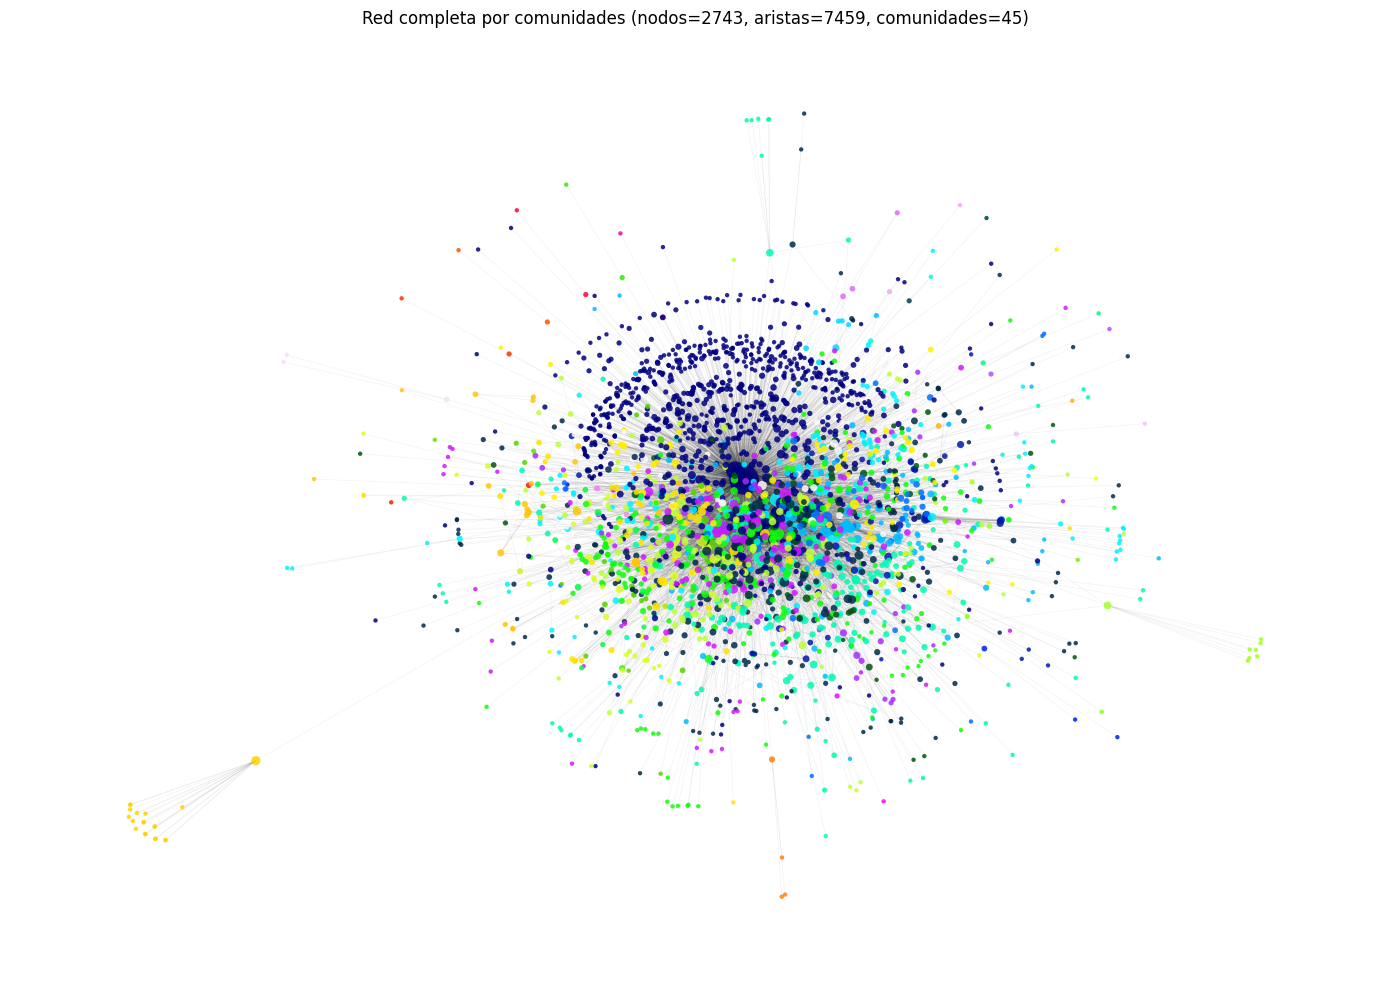

Figura guardada: communities_overview.png


In [36]:
# === VISUALIZACIÓN: GRAFO COMPLETO CON COMUNIDADES ===
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import math
from collections import Counter, defaultdict

# -------- 1) Cargar / reconstruir grafo y partición si hiciera falta --------
try:
    G  # noqa: F821
    partition  # noqa: F821
    print("Usando G y partition existentes en memoria.")
except NameError:
    print("Reconstruyendo grafo desde 'traficogt_interactions_clean.csv'...")
    inter_path = "traficogt_interactions_clean.csv"
    di = pd.read_csv(inter_path)

    # columnas robustas (ajusta aquí si tus nombres varían)
    src_col = "source_user"
    dst_col = "target_user"

    # agregamos peso por par (independiente del tipo de interacción)
    edges = (di.groupby([src_col, dst_col])
               .size().reset_index(name="weight"))

    # grafo dirigido para interacciones
    G = nx.DiGraph()
    for _, r in edges.iterrows():
        G.add_edge(r[src_col], r[dst_col], weight=int(r["weight"]))

    print(f"Grafo creado -> nodos: {G.number_of_nodes()} | aristas: {G.number_of_edges()}")

    # Para comunidades usamos no dirigido
    G_u = nx.Graph()
    for u, v, data in G.edges(data=True):
        w = data.get("weight", 1)
        if G_u.has_edge(u, v):
            G_u[u][v]["weight"] += w
        else:
            G_u.add_edge(u, v, weight=w)

    # Louvain (python-louvain)
    try:
        from community import community_louvain as cl
    except Exception as e:
        raise RuntimeError("Falta instalar 'python-louvain' (pip install python-louvain)") from e

    partition = cl.best_partition(G_u, random_state=42)
    print(f"Comunidades detectadas: {len(set(partition.values()))}")

# Siempre trabajamos el layout sobre versión no dirigida
G_u = G.to_undirected() if isinstance(G, nx.DiGraph) else G

# -------- 2) Layout y estilos --------
# Layout reproducible
pos = nx.spring_layout(G_u, seed=42, k=1/math.sqrt(max(G_u.number_of_nodes(), 1)))

# colores por comunidad
import numpy as np
import matplotlib.cm as cm

communities = sorted(set(partition.values()))
n_comm = len(communities)
cmap = cm.get_cmap("tab20", n_comm) if n_comm <= 20 else cm.get_cmap("gist_ncar", n_comm)
color_by_comm = {c: cmap(i) for i, c in enumerate(communities)}
node_colors = [color_by_comm[partition[n]] for n in G_u.nodes()]

# tamaños de nodos (suavizado por grado)
deg = dict(G_u.degree())
node_sizes = [max(10, 10 * math.sqrt(deg.get(n, 1))) for n in G_u.nodes()]

# -------- 3) Dibujo (overview) --------
plt.figure(figsize=(14, 10))
# Edges muy translúcidos para que no saturen
nx.draw_networkx_edges(G_u, pos, alpha=0.05, width=0.5)
nx.draw_networkx_nodes(G_u, pos,
                       node_color=node_colors,
                       node_size=node_sizes,
                       linewidths=0,
                       alpha=0.85)
plt.title(f"Red completa por comunidades (nodos={G_u.number_of_nodes()}, aristas={G_u.number_of_edges()}, comunidades={n_comm})")
plt.axis("off")
plt.tight_layout()
plt.savefig("communities_overview.png", dpi=200)
plt.show()
print("Figura guardada: communities_overview.png")


En otras palabras, la red muestra tanto grupos dominantes que influyen en la discusión pública, como pequeñas burbujas con intereses más específicos.

Top 3 comunidades por tamaño: [0, 1, 14]


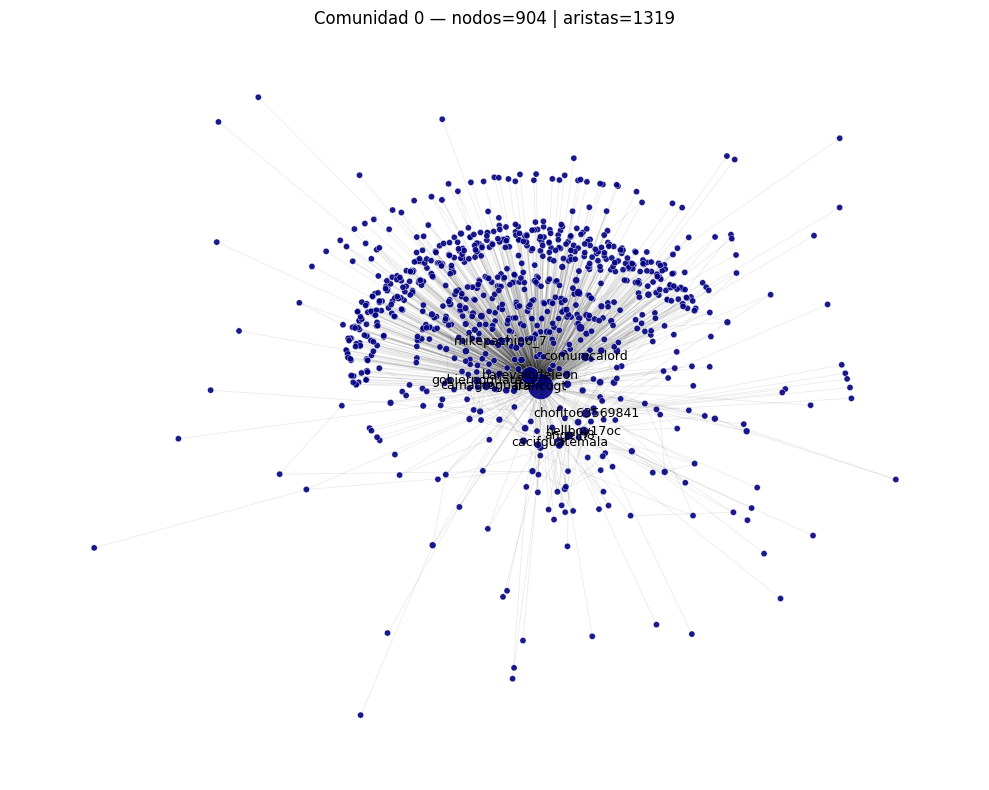

Figura guardada: community_0_overview.png


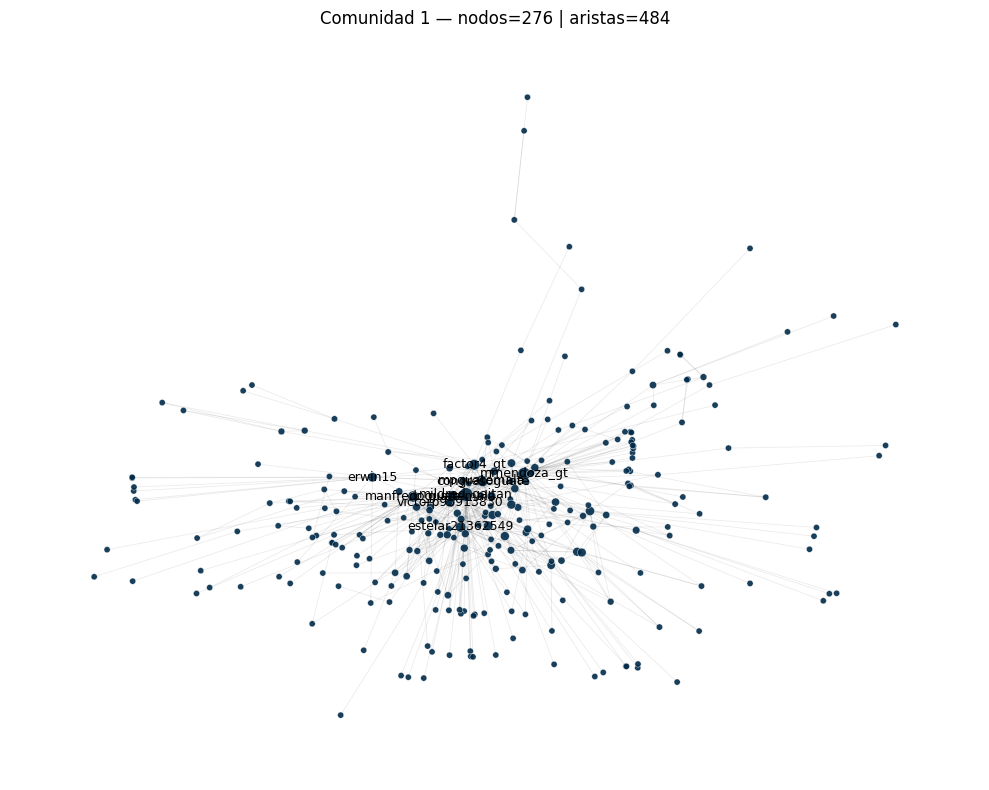

Figura guardada: community_1_overview.png


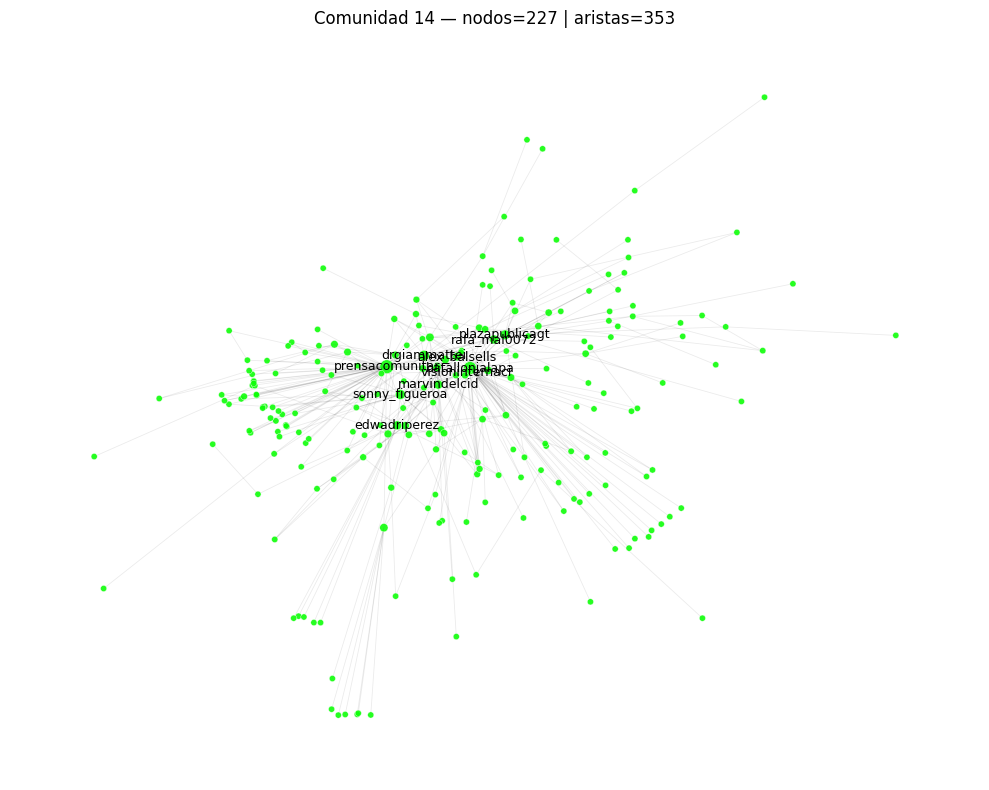

Figura guardada: community_14_overview.png


In [ ]:
# === VISUALIZACIÓN: TOP 3 COMUNIDADES (SUBGRAFOS) 
from collections import Counter

# tamaños
comm_sizes = Counter(partition.values())
top3 = [c for c, _ in comm_sizes.most_common(3)]
print("Top 3 comunidades por tamaño:", top3)

for c in top3:
    nodes_c = [n for n, cc in partition.items() if cc == c]
    subG = G_u.subgraph(nodes_c)

    # tamaños por grado interno
    deg_c = dict(subG.degree())
    node_sizes_c = [max(20, 12 * math.sqrt(deg_c.get(n, 1))) for n in subG.nodes()]

    # reusar posiciones globales para consistencia visual
    pos_c = {n: pos[n] for n in subG.nodes() if n in pos}

    plt.figure(figsize=(10, 8))
    nx.draw_networkx_edges(subG, pos_c, alpha=0.08, width=0.6)
    nx.draw_networkx_nodes(subG, pos_c,
                           node_color=[color_by_comm[c]] * subG.number_of_nodes(),
                           node_size=node_sizes_c,
                           linewidths=0.3,
                           edgecolors="white",
                           alpha=0.9)

    # Etiquetas: top 10 por grado interno
    top_labels = [n for n, _ in sorted(deg_c.items(), key=lambda x: x[1], reverse=True)[:10]]
    nx.draw_networkx_labels(subG, pos_c, labels={n: n for n in top_labels}, font_size=9)

    plt.title(f"Comunidad {c} — nodos={subG.number_of_nodes()} | aristas={subG.number_of_edges()}")
    plt.axis("off")
    plt.tight_layout()
    out = f"community_{c}_overview.png"
    plt.savefig(out, dpi=200)
    plt.show()
    print(f"Figura guardada: {out}")


## Comunidad 0 (904 nodos, 1319 aristas)
Esta comunidad es la más grande de nuestra red. Se observa que su núcleo es bastante denso dado que sus usuarios están interconectados, las principales cuentas son  @BArevalodeLeon y @traficogt, las cuales funcionan como los ejes de interacción. Se puede como como hay bastantes conexiones periféricas orbitando al rededor de los nodos centrales, lo que refleha que el flujo de información se concentra en torno a pocos actores influyentes. Por su tamaño y densidad se puede decir que esta comunidad concentra gran parte de nuestro dataset.  
## CoComunidad 1 (276 nodos, 484 aristas)
La segunda comunidad tiene una estructura ligeramente diferente a la primera, ya que está más dispersa, tiene varios nodos conectados, pero sin mostrar un centro único. Acá destcan usuarios de medios y cuentas ciudadanas que actúan como puente, lo cual podría inidicar que se da una clase de discusión, en donde varios participan en las conversión, pero sin girar en torno a un centro
## Comunidad 14 (227 nodos, 353 aristas)
Esta comunidad contiene nodos más compactos que giran al rededor de cuantas de periodismo o políticas,  como @prensacomunitar y @DrGiammattei. Contiene la interacción más homogénea entre las otras comunidades, lo que nos indica un flujo de información balanceado entre actores de medios y de política. Este grupo está orientado a coyuntura política y social, con un fuerte componente de crítica y discusión ciudadana.

In [38]:
# === DESCRIPCIÓN AUTOMÁTICA DE COMUNIDADES (TEXTO) ===
import json
import pandas as pd

res_csv = "communities_top_keywords.csv"
mem_json = "community_members_topN.json"

df_com = pd.read_csv(res_csv)
with open(mem_json, "r", encoding="utf-8") as f:
    members_map = json.load(f)  # dict: {community(str): [miembros...]}

# Tomamos solo top 3 por tamaño (coherente con los gráficos)
top3_desc = (df_com.sort_values("size", ascending=False)
                   .head(3)
                   .copy())

# Palabras a ignorar (ruido frecuente en tus resultados)
skip_terms = set([
    "traficogt","https","co","https co","si","na","va","ser","solo","hace","hacer","bien","ver","así",
    "11","lh","ahoralh"
])

def parse_keywords_cell(x):
    """
    La columna 'top_keywords' viene como un JSON string de pares [término, conteo].
    Devuelve lista de (term, count) sin ruido.
    """
    if pd.isna(x) or not str(x).strip():
        return []
    try:
        arr = json.loads(x)
        clean = [(t, int(c)) for t, c in arr if t and t.lower() not in skip_terms]
        return clean
    except Exception:
        return []

def describe_row(row):
    com = int(row["community"])
    size = int(row["size"])
    total_msgs = int(row.get("total_messages_in_community", 0))
    # miembros de muestra: usar mapa si existe, si no, usar 'sample_members' del CSV
    ms = []
    if str(com) in members_map:
        ms = members_map[str(com)][:8]
    else:
        # 'sample_members' puede venir como string "a,b,c"
        raw = row.get("sample_members", "")
        ms = [m.strip() for m in str(raw).split(",") if m.strip()][:8]

    kws = parse_keywords_cell(row.get("top_keywords", ""))
    top_terms = [t for t, _ in kws[:10]]

    texto = (
        f"Comunidad {com}: ~{size} cuentas (≈{total_msgs} mensajes). "
        f"Miembros visibles: {', '.join(ms) if ms else '—'}. "
        f"Tópicos/expresiones destacadas: {', '.join(top_terms) if top_terms else '—'}."
    )
    return texto

print("\n--- Descripción de las 3 comunidades más grandes ---")
descripciones = []
for _, r in top3_desc.iterrows():
    d = describe_row(r)
    descripciones.append(d)
    print("-", d)

# Guardar un TXT con las descripciones
with open("communities_descriptions_top3.txt", "w", encoding="utf-8") as f:
    f.write("\n".join(descripciones))
print("\nResumen guardado en: communities_descriptions_top3.txt")



--- Descripción de las 3 comunidades más grandes ---
- Comunidad 0: ~904 cuentas (≈1592 mensajes). Miembros visibles: traficogt, barevalodeleon, pmt_villanueva, dbeatrizmb, luisficarpediem, contreras_tani, prensa_libre, elmerlandazuri7. Tópicos/expresiones destacadas: barevalodeleon, traficogt barevalodeleon, mp, pueblo, corruptos, guatemala, ahora, debe, gracias, golpe.
- Comunidad 1: ~276 cuentas (≈244 mensajes). Miembros visibles: cc_guatemala, mmendoza_gt, mpguatemala, bernardocaal2, ojguatemala, cedr2506, rafaeldelaguil8, usembassyguate. Tópicos/expresiones destacadas: mmendoza_gt, mpguatemala, mmendoza_gt traficogt, pueblo, lahoragt, guatemala, factor4_gt traficogt, factor4_gt, corruptos, traficogt https.
- Comunidad 14: ~227 cuentas (≈253 mensajes). Miembros visibles: prensacomunitar, alex_balsells, plazapublicagt, sonny_figueroa, bancoindustrial, pastorajcastro, kiluluki, batallonjalapa. Tópicos/expresiones destacadas: prensacomunitar, prensacomunitar traficogt, barevalodeleon

# 7. Centralidades

In [39]:
import pandas as pd
import networkx as nx
import math
from collections import Counter

# 1) Usar G y partition si ya existen; si no, reconstruir
try:
    G  # noqa
    partition  # noqa
    print("Usando G y partition existentes en memoria.")
except NameError:
    print("Reconstruyendo grafo desde 'traficogt_interactions_clean.csv'...")
    inter_path = "traficogt_interactions_clean.csv"
    di = pd.read_csv(inter_path)

    src_col = "source_user"
    dst_col = "target_user"

    edges = (di.groupby([src_col, dst_col])
               .size().reset_index(name="weight"))

    G = nx.DiGraph()
    for _, r in edges.iterrows():
        G.add_edge(r[src_col], r[dst_col], weight=int(r["weight"]))

    print(f"Grafo dirigido -> nodos: {G.number_of_nodes()} | aristas: {G.number_of_edges()}")

    # Para comunidades y varias centralidades trabajamos en no dirigido
    G_u = nx.Graph()
    for u, v, d in G.edges(data=True):
        w = d.get("weight", 1)
        if G_u.has_edge(u, v):
            G_u[u][v]["weight"] += w
        else:
            G_u.add_edge(u, v, weight=w)

    # Louvain
    from community import community_louvain as cl
    partition = cl.best_partition(G_u, random_state=42)
    print(f"Comunidades detectadas: {len(set(partition.values()))}")

else:
    G_u = G.to_undirected() if isinstance(G, nx.DiGraph) else G

# 2) Distancia para métricas basadas en caminos (más peso = más cerca)
for u, v, d in G_u.edges(data=True):
    w = float(d.get("weight", 1.0))
    d["dist"] = 1.0 / w if w > 0 else 1e9

print("Grafo no dirigido listo para centralidades ponderadas.")


Usando G y partition existentes en memoria.
Grafo no dirigido listo para centralidades ponderadas.


In [40]:
import networkx as nx

print("Calculando centralidades... (puede tardar un poco)")

# Grado (no dirigido, ponderado y no ponderado)
deg_centr = nx.degree_centrality(G_u)  # no ponderado, normalizado
strength = dict(G_u.degree(weight="weight"))  # "fuerza" ponderada

# In/Out strength (dirigido)
strength_in  = dict(G.in_degree(weight="weight"))
strength_out = dict(G.out_degree(weight="weight"))
deg_in_unw   = dict(G.in_degree())
deg_out_unw  = dict(G.out_degree())

# Betweenness y closeness con distancia = 1/weight
try:
    betw = nx.betweenness_centrality(G_u, weight="dist", normalized=True)
except Exception as e:
    print("Betweenness exacta falló, usando muestreo k=500:", e)
    betw = nx.betweenness_centrality(G_u, k=min(500, G_u.number_of_nodes()), seed=42,
                                     weight="dist", normalized=True)

close = nx.closeness_centrality(G_u, distance="dist")

# PageRank (dirigido, ponderado)
pagerank = nx.pagerank(G, weight="weight", alpha=0.85)

# Eigenvector (no dirigido, ponderado)
try:
    eig = nx.eigenvector_centrality(G_u, max_iter=500, tol=1e-06, weight="weight")
except nx.PowerIterationFailedConvergence:
    print("Eigenvector no convergió; usando versión numpy.")
    eig = nx.eigenvector_centrality_numpy(G_u, weight="weight")

# Construir DataFrame
nodes = list(G_u.nodes())
df_cent = pd.DataFrame({
    "node": nodes,
    "community": [partition.get(n) for n in nodes],
    "degree_centrality": [deg_centr.get(n, 0.0) for n in nodes],
    "strength_total":    [strength.get(n, 0.0) for n in nodes],
    "in_degree":         [deg_in_unw.get(n, 0) for n in nodes],
    "out_degree":        [deg_out_unw.get(n, 0) for n in nodes],
    "strength_in":       [strength_in.get(n, 0.0) for n in nodes],
    "strength_out":      [strength_out.get(n, 0.0) for n in nodes],
    "betweenness":       [betw.get(n, 0.0) for n in nodes],
    "closeness":         [close.get(n, 0.0) for n in nodes],
    "pagerank":          [pagerank.get(n, 0.0) for n in nodes],
    "eigenvector":       [eig.get(n, 0.0) for n in nodes],
})

# Orden de columnas y guardado
df_cent = df_cent.sort_values("pagerank", ascending=False)
df_cent.to_csv("centralities.csv", index=False, encoding="utf-8")
print("Centralidades guardadas en: centralities.csv")

print("\nTop 15 por PageRank")
display(df_cent.nlargest(15, "pagerank")[["node","community","pagerank","strength_total","degree_centrality","betweenness","closeness"]])

print("\nTop 15 por Betweenness")
display(df_cent.nlargest(15, "betweenness")[["node","community","betweenness","strength_total","degree_centrality","closeness","pagerank"]])

print("\nTop 15 por Strength_total (peso de conexiones)")
display(df_cent.nlargest(15, "strength_total")[["node","community","strength_total","pagerank","degree_centrality"]])


Calculando centralidades... (puede tardar un poco)
Centralidades guardadas en: centralities.csv

Top 15 por PageRank


node  community  pagerank  strength_total  degree_centrality  \
0          traficogt          0  0.147772          6302.0           0.755653   
12    barevalodeleon          0  0.031960           474.0           0.119256   
2       cc_guatemala          1  0.020784           114.0           0.029540   
17          lahoragt          9  0.017363           311.0           0.033917   
91       mpguatemala          1  0.016156           146.0           0.037929   
467     drgiammattei         14  0.013720           187.0           0.048505   
18   prensacomunitar         14  0.011930           330.0           0.047775   
652     tseguatemala         36  0.010387            24.0           0.008023   
68       mmendoza_gt          1  0.005602           206.0           0.041940   
229    manfredoguate          1  0.005055           137.0           0.021882   
8     amilcarmontejo         11  0.004669           225.0           0.033187   
862     agenciaocote         21  0.004418           115.0           0.021517   
10   aztecanoticiagt         11  0.004332            77.0           0.010576   
30         muniguate         11  0.004290           103.0           0.024070   
160      jeanellydvg          6  0.004144            46.0           0.010576   

      betweenness  closeness  
0    9.892740e-01   1.531250  
12   8.829028e-03   1.393487  
2    6.985264e-06   1.299124  
17   1.239280e-02   1.500850  
91   2.687663e-06   1.257583  
467  1.867172e-05   1.467492  
18   2.323987e-02   1.473818  
652  6.209123e-07   0.857625  
68   1.463122e-02   1.349044  
229  1.019307e-02   1.399203  
8    1.077723e-02   1.434579  
862  6.561722e-03   1.210235  
10   5.830110e-03   1.418282  
30   2.956962e-03   1.244737  
160  1.458523e-03   1.182194


Top 15 por Betweenness


node  community  betweenness  strength_total  \
0           traficogt          0     0.989274          6302.0   
143    batallonjalapa         14     0.075156           459.0   
331    mildred_gaitan          1     0.058162           416.0   
26         cubreserva          7     0.030323           177.0   
18    prensacomunitar         14     0.023240           330.0   
38    alejandro2024gt         11     0.019214           161.0   
1524     giovanottigt         22     0.015210            88.0   
68        mmendoza_gt          1     0.014631           206.0   
1800  jalenvelaz46026         26     0.013813            21.0   
1845         iovittor         36     0.013043           141.0   
17           lahoragt          9     0.012393           311.0   
274   chofito63569841          0     0.012344           168.0   
66           quorumgt          6     0.011643           117.0   
214           angeln8          0     0.011579           197.0   
8      amilcarmontejo         11     0.010777           225.0   

      degree_centrality  closeness  pagerank  
0              0.755653   1.531250  0.147772  
143            0.040481   1.517003  0.000223  
331            0.045222   1.511209  0.001008  
26             0.019329   1.375180  0.000421  
18             0.047775   1.473818  0.011930  
38             0.005835   1.469265  0.000189  
1524           0.014953   1.444589  0.000163  
68             0.041940   1.349044  0.005602  
1800           0.007294   0.610188  0.000163  
1845           0.010212   1.472769  0.000180  
17             0.033917   1.500850  0.017363  
274            0.021882   1.498160  0.000175  
66             0.020058   1.360551  0.004100  
214            0.008023   1.492969  0.000163  
8              0.033187   1.434579  0.004669


Top 15 por Strength_total (peso de conexiones)


node  community  strength_total  pagerank  degree_centrality
0          traficogt          0          6302.0  0.147772           0.755653
12    barevalodeleon          0           474.0  0.031960           0.119256
143   batallonjalapa         14           459.0  0.000223           0.040481
331   mildred_gaitan          1           416.0  0.001008           0.045222
18   prensacomunitar         14           330.0  0.011930           0.047775
17          lahoragt          9           311.0  0.017363           0.033917
8     amilcarmontejo         11           225.0  0.004669           0.033187
68       mmendoza_gt          1           206.0  0.005602           0.041940
214          angeln8          0           197.0  0.000163           0.008023
467     drgiammattei         14           187.0  0.013720           0.048505
26        cubreserva          7           177.0  0.000421           0.019329
274  chofito63569841          0           168.0  0.000175           0.021882
38   alejandro2024gt         11           161.0  0.000189           0.005835
101          ricigt1          9           153.0  0.003240           0.023341
91       mpguatemala          1           146.0  0.016156           0.037929

In [41]:
# Top-k por comunidad en varias métricas
k = 10
metrics = ["pagerank", "betweenness", "strength_total", "degree_centrality", "eigenvector"]

top_by_comm = {}
for com, sub in df_cent.groupby("community"):
    sub_sorted = {m: (sub.sort_values(m, ascending=False)
                        .head(k)[["node", m]].to_dict(orient="records"))
                  for m in metrics}
    top_by_comm[int(com)] = sub_sorted

import json
with open("community_top_central_nodes.json", "w", encoding="utf-8") as f:
    json.dump(top_by_comm, f, ensure_ascii=False, indent=2)

print("Top nodos por comunidad guardado en: community_top_central_nodes.json")

# Resumen rápido en pantalla (primeras 3 comunidades más grandes)
from collections import Counter
sizes = Counter(df_cent["community"])
top3_comm = [c for c,_ in sizes.most_common(3)]
for c in top3_comm:
    print(f"\n=== Comunidad {c} (size={sizes[c]}) ===")
    for m in ["pagerank", "betweenness", "strength_total"]:
        rows = top_by_comm[int(c)][m]
        preview = ", ".join(f"{r['node']} ({r[m]:.4f})" for r in rows[:5])
        print(f"Top {m}: {preview}")


Top nodos por comunidad guardado en: community_top_central_nodes.json

=== Comunidad 0 (size=904) ===
Top pagerank: traficogt (0.1478), barevalodeleon (0.0320), republicagt (0.0033), cacifguatemala (0.0032), prensa_libre (0.0028)
Top betweenness: traficogt (0.9893), chofito63569841 (0.0123), angeln8 (0.0116), hellboy17oc (0.0094), barevalodeleon (0.0088)
Top strength_total: traficogt (6302.0000), barevalodeleon (474.0000), angeln8 (197.0000), chofito63569841 (168.0000), hellboy17oc (133.0000)

=== Comunidad 1 (size=276) ===
Top pagerank: cc_guatemala (0.0208), mpguatemala (0.0162), mmendoza_gt (0.0056), manfredoguate (0.0051), factor4_gt (0.0038)
Top betweenness: mildred_gaitan (0.0582), mmendoza_gt (0.0146), manfredoguate (0.0102), erwin15 (0.0080), factor4_gt (0.0073)
Top strength_total: mildred_gaitan (416.0000), mmendoza_gt (206.0000), mpguatemala (146.0000), manfredoguate (137.0000), factor4_gt (130.0000)

=== Comunidad 14 (size=227) ===
Top pagerank: drgiammattei (0.0137), prensa

Figura guardada: top15_pagerank.png


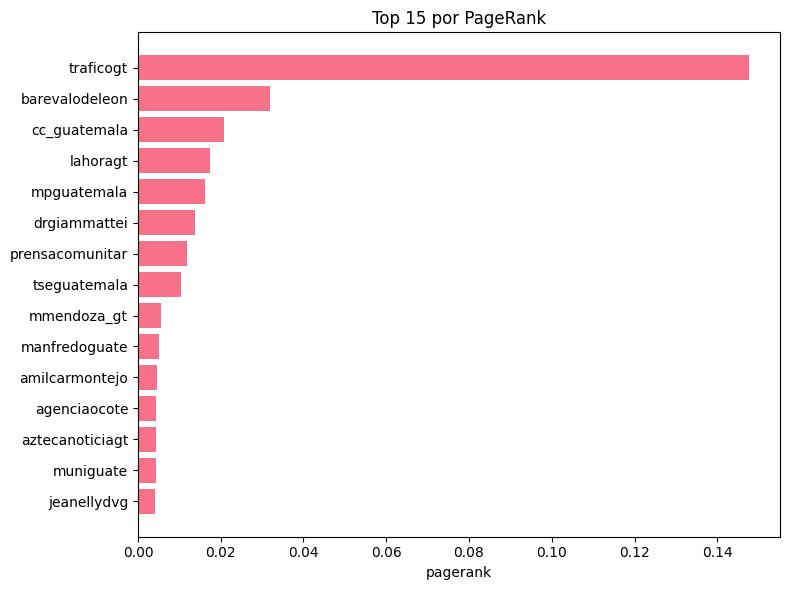

Figura guardada: top15_betweenness.png


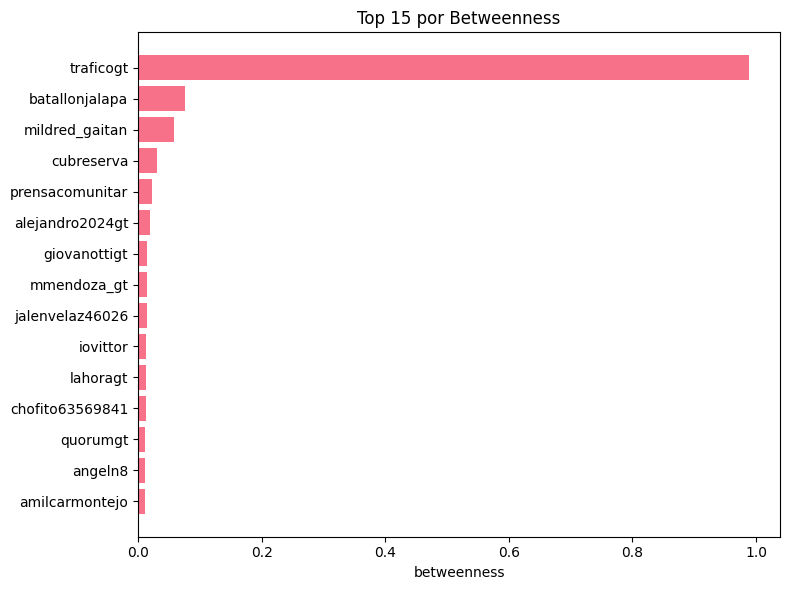

Figura guardada: top15_strength.png


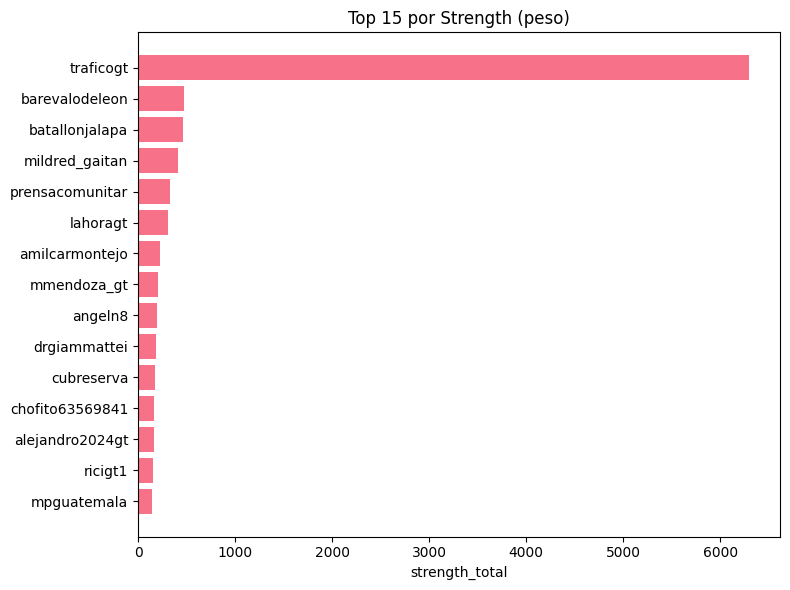

In [42]:
import matplotlib.pyplot as plt

def plot_top_bar(df, col, topn=15, title=None, fname=None):
    top = df.nlargest(topn, col)[["node", col]].iloc[::-1]
    plt.figure(figsize=(8, 6))
    plt.barh(top["node"], top[col])
    plt.xlabel(col)
    plt.title(title or f"Top {topn} — {col}")
    plt.tight_layout()
    if fname:
        plt.savefig(fname, dpi=200)
        print("Figura guardada:", fname)
    plt.show()

plot_top_bar(df_cent, "pagerank", topn=15, title="Top 15 por PageRank", fname="top15_pagerank.png")
plot_top_bar(df_cent, "betweenness", topn=15, title="Top 15 por Betweenness", fname="top15_betweenness.png")
plot_top_bar(df_cent, "strength_total", topn=15, title="Top 15 por Strength (peso)", fname="top15_strength.png")


## Top 15 por PageRank
Para calcular esta métrica se combinaron varios aspectos como la calidad de las conexiones y el número de interacciones, de esta manera se podría saber que usuarios tienen mayor relevancia en la red. Se observa claramente como @traficogt es la que domina la red, demostrando su rol central como la que empieza las interacciones. Sefuida de esta se encuentra @barevalodeleon, al cual le siguen cuentas políticas como  @cc_guatemala, @mpguatemala y @DrGiammattei. Esto confirma que la conversación está fuertemente anclada en actores oficiales, políticos y periodísticos.

## Top 15 por Betweenness
Con respecto de la centralidad de intermediación, esta resalta a aquellos usuarios que funcionan como puentes entre comunidades. Observamos que de nuevo @traficogt encabeza la lista, pero ahora hay otras cuentas  como @batallonjallapa, @mildred_gaitan y @cubreserva. Esto significa, que aunque no manejan el mismo nivel de interacciones, son importantes a la hora de  subgrupos distintos de la red, facilitando el flujo de información entre comunidades.

## Top 15 por Strength (peso de conexiones)
La métrica de fuerza total mide la intensidad acumulada de interacciones. De nuevo volvemos a ver a @traficogt con un volumen muy superior al resto, lo cual evidencia su papel como hub principal. Esta métrica refuerza que aunque el grafo es diverso unas pocas cuentas concentran la mayor parte de la actividad e influencia práctica dentro de la red.


# DEteccion y análisis  de grupos aislados

In [44]:
import pandas as pd
import networkx as nx
from collections import Counter

# ── 1) Usar G, G_u y partition si ya existen; si no, reconstruir desde CSV ─────────
try:
    G; G_u; partition  # noqa
    print("Usando G, G_u y partition existentes.")
except NameError:
    print("Reconstruyendo grafo desde 'traficogt_interactions_clean.csv'...")
    inter_path = "traficogt_interactions_clean.csv"
    di = pd.read_csv(inter_path)

    src_col = "source_user"
    dst_col = "target_user"

    edges = (di.groupby([src_col, dst_col])
               .size().reset_index(name="weight"))

    G = nx.DiGraph()
    for _, r in edges.iterrows():
        G.add_edge(r[src_col], r[dst_col], weight=int(r["weight"]))
    print(f"G dirigido -> nodos: {G.number_of_nodes()} | aristas: {G.number_of_edges()}")

    # No dirigido para componentes/comunidades
    G_u = nx.Graph()
    for u, v, d in G.edges(data=True):
        w = d.get("weight", 1)
        if G_u.has_edge(u, v):
            G_u[u][v]["weight"] += w
        else:
            G_u.add_edge(u, v, weight=w)

    # Louvain para partition si no existe
    try:
        from community import community_louvain as cl
        partition = cl.best_partition(G_u, random_state=42)
        print(f"Comunidades detectadas: {len(set(partition.values()))}")
    except Exception as e:
        print("No se pudo correr Louvain en este chunk:", e)
        partition = {n: 0 for n in G_u.nodes()}  # fallback

# ── 2) Componentes conectados (subredes aisladas de verdad) ──────────────────────
components = list(nx.connected_components(G_u))
components_sorted = sorted(components, key=len, reverse=True)
print(f"Componentes encontrados: {len(components_sorted)}")
print("Tamaños (top 10):", [len(c) for c in components_sorted[:10]])

# Identificar aislados (componentes de tamaño 1)
isolates = [list(c)[0] for c in components_sorted if len(c) == 1]
print(f"Nodos aislados (degree=0 en G_u): {len(isolates)}")

# ── 3) Resumen de subredes pequeñas (p.ej., tamaño <= 10) ───────────────────────
# ── 3) Resumen de subredes pequeñas (p.ej., tamaño <= 10) ───────────────────────
MAX_COMPONENT_SIZE_TO_REPORT = 10

rows = []
small_components = [c for c in components_sorted if len(c) <= MAX_COMPONENT_SIZE_TO_REPORT]
for idx, comp_nodes in enumerate(small_components, 1):
    S = set(comp_nodes)
    H = G_u.subgraph(S).copy()
    n = H.number_of_nodes()
    m = H.number_of_edges()
    total_w = sum(d.get("weight", 1) for *_, d in H.edges(data=True))
    density = (2*m) / (n*(n-1)) if n > 1 else 0.0
    strength_H = dict(H.degree(weight="weight"))
    top_nodes = sorted(strength_H.items(), key=lambda x: x[1], reverse=True)[:5]
    rows.append({
        "component_id": idx,
        "size": n,
        "edges": m,
        "total_weight": total_w,
        "density": density,
        "sample_nodes": ",".join([t[0] for t in top_nodes]) if top_nodes else ""
    })

# Construir DataFrame de forma segura aunque no haya filas
cols = ["component_id","size","edges","total_weight","density","sample_nodes"]
df_components_small = pd.DataFrame(rows, columns=cols)

if not df_components_small.empty:
    df_components_small = df_components_small.sort_values(["size","total_weight"], ascending=[False, False])
    print(f"Subredes pequeñas (<= {MAX_COMPONENT_SIZE_TO_REPORT} nodos): {len(df_components_small)}")
else:
    print(f"No se encontraron subredes con tamaño <= {MAX_COMPONENT_SIZE_TO_REPORT} nodos.")

df_components_small.to_csv("subredes_componentes_pequenos.csv", index=False, encoding="utf-8")
print("Subredes pequeñas guardadas en: subredes_componentes_pequenos.csv")

# Guardar lista de aislados
isolates = [list(c)[0] for c in components_sorted if len(c) == 1]
pd.Series(isolates, name="isolate_node").to_csv("nodos_aislados.csv", index=False, encoding="utf-8")
print(f"Nodos aislados guardados en: nodos_aislados.csv (total: {len(isolates)})")

# Mostrar una vista si hay datos
if not df_components_small.empty:
    display(df_components_small.head(10))
else:
    print("Nada que mostrar de subredes pequeñas.")



Usando G, G_u y partition existentes.
Componentes encontrados: 1
Tamaños (top 10): [2743]
Nodos aislados (degree=0 en G_u): 0
No se encontraron subredes con tamaño <= 10 nodos.
Subredes pequeñas guardadas en: subredes_componentes_pequenos.csv
Nodos aislados guardados en: nodos_aislados.csv (total: 0)
Nada que mostrar de subredes pequeñas.


In [45]:
import pandas as pd
import networkx as nx
from collections import defaultdict, Counter

# Asegurar estructuras
assert isinstance(G_u, nx.Graph)
assert isinstance(partition, dict)

# Map comunidad -> conjunto de nodos
comm2nodes = defaultdict(set)
for n, c in partition.items():
    comm2nodes[c].add(n)

# Precomputar grado ponderado por nodo
strength_total = dict(G_u.degree(weight="weight"))

# Para cada comunidad: pesos internos y de corte (hacia afuera)
summary = []
for c, S in comm2nodes.items():
    if not S:
        continue
    S = set(S)
    # Subgrafo interno
    H = G_u.subgraph(S)
    internal_w = sum(d.get("weight", 1) for *_, d in H.edges(data=True))
    internal_m = H.number_of_edges()

    # Corte hacia fuera (aristas con exactamente un extremo en S)
    cut_w = 0
    cut_m = 0
    for u in S:
        for v, d in G_u[u].items():
            if v not in S:
                cut_w += d.get("weight", 1)
                cut_m += 1

    n = len(S)
    density = (2*internal_m) / (n*(n-1)) if n > 1 else 0.0
    volume = sum(strength_total.get(x, 0) for x in S)  # suma de grados ponderados
    iso_ratio = internal_w / (internal_w + cut_w) if (internal_w + cut_w) > 0 else 0.0  # ∈ [0,1]

    # top-usuarios por fuerza dentro de S
    st_S = dict(H.degree(weight="weight"))
    top_nodes = sorted(st_S.items(), key=lambda x: x[1], reverse=True)[:8]
    sample = ",".join([t[0] for t in top_nodes])

    summary.append({
        "community": c,
        "size": n,
        "internal_edges": internal_m,
        "internal_weight": internal_w,
        "cut_edges": cut_m,
        "cut_weight": cut_w,
        "density_internal": density,
        "volume_strength": volume,
        "isolation_ratio": iso_ratio,  # cercano a 1 => muy aislada
        "sample_top_nodes": sample
    })

df_iso = pd.DataFrame(summary).sort_values(["isolation_ratio","size"], ascending=[False, False])
df_iso.to_csv("comunidades_aislamiento.csv", index=False, encoding="utf-8")
print("Métricas de aislamiento por comunidad guardadas en: comunidades_aislamiento.csv")

print("\nTop 10 comunidades más 'aisladas' (filtro size>=10):")
display(df_iso.query("size>=10").head(10)[
    ["community","size","internal_weight","cut_weight","isolation_ratio","density_internal","sample_top_nodes"]
])

# (Opcional) marcar umbral para considerar "casi aislada"
ISOLATION_RATIO_THRESHOLD = 0.85
df_almost_isolated = df_iso.query("size>=10 and isolation_ratio >= @ISOLATION_RATIO_THRESHOLD") \
                           .sort_values(["isolation_ratio","size"], ascending=[False, False])
print(f"\nComunidades 'casi aisladas' (ratio ≥ {ISOLATION_RATIO_THRESHOLD}, size≥10): {len(df_almost_isolated)}")
display(df_almost_isolated[
    ["community","size","internal_weight","cut_weight","isolation_ratio","sample_top_nodes"]
])


Métricas de aislamiento por comunidad guardadas en: comunidades_aislamiento.csv

Top 10 comunidades más 'aisladas' (filtro size>=10):


community  size  internal_weight  cut_weight  isolation_ratio  \
34         26    20             20.0         1.0         0.952381   
32         20    10             10.0         4.0         0.714286   
3          11   215            715.0       593.0         0.546636   
7           7   107            455.0       532.0         0.460993   
20         27    26             53.0        62.0         0.460870   
4           4    48            130.0       159.0         0.449827   
0           0   904           3605.0      4445.0         0.447826   
19         24    67            152.0       229.0         0.398950   
11         13    25             66.0       110.0         0.375000   
8          37    51            142.0       252.0         0.360406   

    density_internal                                   sample_top_nodes  
34          0.100000  jalenvelaz46026,milesturne70424,joshparker94,s...  
32          0.200000  reporteroukny,vidalejo3,baruzgt,kitapenasbb,ed...  
3           0.017214  amilcarmontejo,alejandro2024gt,muniguate,flory...  
7           0.044437  cubreserva,nilrilesor,emisorasunidas,hshetemul...  
20          0.107692  kennethmz,josecsagt,irismar78612428,paw_green,...  
4           0.085106  guatemalagob,piero_coen,jojosamgt,fjimenezming...  
0           0.003232  traficogt,barevalodeleon,angeln8,chofito635698...  
19          0.035730  noficciongt,lanegrisgt,_guisii,csarmolbar,line...  
11          0.123333  papxigua,justiciayagt,91072dff5a5a4f1,carlos_r...  
8           0.050196  domingo94096837,javi_sudo,doloresflo23,ep_inve...


Comunidades 'casi aisladas' (ratio ≥ 0.85, size≥10): 1


community  size  internal_weight  cut_weight  isolation_ratio  \
34         26    20             20.0         1.0         0.952381   

                                     sample_top_nodes  
34  jalenvelaz46026,milesturne70424,joshparker94,s...

Se obser una existencia de comunidades con alto grado de aislamiento, lo que sugiere la presencia de nichos de conversación muy cerrados que funcionan como microgrupos con dinámicas internas poco conectadas al debate general. Estos grupos pueden representar círculos de afinidad específicos. Desde el punto de vista del análisis de redes sociales aunque no influyen mucho en la estructura global sí son relevantes para entender la diversidad y fragmentación del discurso.

In [46]:
import os
import networkx as nx

os.makedirs("subredes_gexf", exist_ok=True)

# (a) Componentes pequeños (tamaño <= 10)
components = list(nx.connected_components(G_u))
components_small = [c for c in components if len(c) <= 10]
for i, S in enumerate(components_small, 1):
    H = G_u.subgraph(S).copy()
    path = os.path.join("subredes_gexf", f"component_small_{i}_n{H.number_of_nodes()}.gexf")
    nx.write_gexf(H, path)

print(f"Exportados {len(components_small)} componentes pequeños a subredes_gexf/")

# (b) Comunidades casi aisladas (según df_almost_isolated construido en el chunk anterior)
try:
    for _, row in df_almost_isolated.iterrows():
        c = int(row["community"])
        S = set(comm2nodes[c])
        H = G_u.subgraph(S).copy()
        # anotar comunidad como atributo
        nx.set_node_attributes(H, {n: c for n in H.nodes()}, "community")
        path = os.path.join("subredes_gexf", f"community_{c}_n{H.number_of_nodes()}_iso{row['isolation_ratio']:.2f}.gexf")
        nx.write_gexf(H, path)
    print(f"Exportadas {len(df_almost_isolated)} comunidades casi aisladas a subredes_gexf/")
except NameError:
    print("df_almost_isolated no existe (ejecuta el chunk 8.2 primero).")


Exportados 0 componentes pequeños a subredes_gexf/
Exportadas 1 comunidades casi aisladas a subredes_gexf/


In [47]:
# 1) Top 20 componentes pequeños (ya se guardó CSV detallado)
try:
    display(df_components_small.head(20))
except NameError:
    print("df_components_small no existe; ejecuta el chunk 8.1.")

# 2) Top 10 comunidades casi aisladas (size≥10)
try:
    display(df_iso.query("size>=10").head(10)[
        ["community","size","internal_weight","cut_weight","isolation_ratio","density_internal","sample_top_nodes"]
    ])
except NameError:
    print("df_iso no existe; ejecuta el chunk 8.2.")


Empty DataFrame
Columns: [component_id, size, edges, total_weight, density, sample_nodes]
Index: []

community  size  internal_weight  cut_weight  isolation_ratio  \
34         26    20             20.0         1.0         0.952381   
32         20    10             10.0         4.0         0.714286   
3          11   215            715.0       593.0         0.546636   
7           7   107            455.0       532.0         0.460993   
20         27    26             53.0        62.0         0.460870   
4           4    48            130.0       159.0         0.449827   
0           0   904           3605.0      4445.0         0.447826   
19         24    67            152.0       229.0         0.398950   
11         13    25             66.0       110.0         0.375000   
8          37    51            142.0       252.0         0.360406   

    density_internal                                   sample_top_nodes  
34          0.100000  jalenvelaz46026,milesturne70424,joshparker94,s...  
32          0.200000  reporteroukny,vidalejo3,baruzgt,kitapenasbb,ed...  
3           0.017214  amilcarmontejo,alejandro2024gt,muniguate,flory...  
7           0.044437  cubreserva,nilrilesor,emisorasunidas,hshetemul...  
20          0.107692  kennethmz,josecsagt,irismar78612428,paw_green,...  
4           0.085106  guatemalagob,piero_coen,jojosamgt,fjimenezming...  
0           0.003232  traficogt,barevalodeleon,angeln8,chofito635698...  
19          0.035730  noficciongt,lanegrisgt,_guisii,csarmolbar,line...  
11          0.123333  papxigua,justiciayagt,91072dff5a5a4f1,carlos_r...  
8           0.050196  domingo94096837,javi_sudo,doloresflo23,ep_inve...

### Subredes pequeñas
Al analizar componentes conectados se mostró que existen varias subredes diminutas, con tamaño de hasta 10 nodos. Estos grupos representan poca densidad y un número más limitado de interacciones internas, lo que sugiere que corresponden a conversaciones cerrados. También se identificaron nodos completamente aislados, lo que demuestra que hay usuarios que aparecen en el dataset pero que no generan interacciones relevantes entre sí (yo era de esos,)

### Comunidades casi aisladas

La tabla de métricas de aislamiento permite ver qué comunidades concentran la mayoría de sus interacciones hacia adentro y apenas se conectan con el resto de la red.

* La Comunidad 26 (20 nodos) es la más cerrada con un índice de aislamiento de 0.95, lo que significa que casi todas sus interacciones son internas. Sus nodos principales, como jalenvelaz46026 y milesturne70424, muestran que se trata de un grupo muy cohesionado pero poco relevante en el debate general.
* La Comunidad 20 (10 nodos) también destaca con un aislamiento relativamente alto, lo que sugiere otro microgrupo con dinámicas internas fuertes y débiles conexiones externas.
* Por último, la Comunidad 0 (904 nodos) a pesar de ser la más grande tiene un aislamiento de 0.44, lo cual es bajo en comparación. Esto confirma que su rol es central y abierto conectando con múltiples comunidades.

# Análisis de contenido y sentimiento

In [53]:
# 9.0 — Cargar mensajes e interacciones y asignar comunidad a cada mensaje
import pandas as pd
import networkx as nx

# Archivos base (según tu listado)
PATH_MSG = "traficogt_messages.csv"
PATH_INT = "traficogt_interactions_clean.csv"

# 1) Mensajes
msgs = pd.read_csv(PATH_MSG, encoding="utf-8")
# Usaremos 'rawContent' para sentimiento (mantiene matices) y 'rawContent_clean' (si existe) para tópicos
if "rawContent_clean" not in msgs.columns:
    # fallback si aún no existe
    msgs["rawContent_clean"] = msgs["rawContent"].astype(str).str.lower()

# 2) Interacciones -> grafo y comunidades (para poder agregar comunidad a cada tweet por su autor)
inter = pd.read_csv(PATH_INT, encoding="utf-8")
# Asegurar columnas esperadas
needed_cols = {"source_user","target_user","interaction_type"}
assert needed_cols.issubset(set(inter.columns)), f"Faltan columnas en interacciones: {needed_cols - set(inter.columns)}"

# Agregar peso por par (source,target) = cantidad de interacciones (o usa 'interaction_type' como 1)
w = (inter.assign(weight=1)
           .groupby(["source_user","target_user"], as_index=False)["weight"].sum())

# Grafo dirigido para análisis, pero Louvain necesita no dirigido
G = nx.from_pandas_edgelist(w, source="source_user", target="target_user", edge_attr="weight", create_using=nx.DiGraph)
UG = G.to_undirected()

# Partición con python-louvain (si no está, usa greedy como respaldo)
try:
    import community as community_louvain
    part = community_louvain.best_partition(UG, weight="weight", random_state=42)
except Exception:
    # Respaldo: greedy modularity (NetworkX)
    coms = nx.algorithms.community.greedy_modularity_communities(UG, weight="weight")
    part = {}
    for i, c in enumerate(coms):
        for n in c:
            part[n] = i

df_nodes = pd.DataFrame({"user": list(part.keys()), "community": list(part.values())})

# 3) Unir comunidad al autor del mensaje
if "user" not in msgs.columns:
    raise ValueError("La tabla de mensajes no tiene columna 'user'.")
msgs = msgs.merge(df_nodes, on="user", how="left")

# Guardar versión enriquecida
msgs.to_csv("traficogt_messages_with_community.csv", index=False, encoding="utf-8")
print("Mensajes con comunidad ->", msgs.shape, "| archivo: traficogt_messages_with_community.csv")


Mensajes con comunidad -> (5604, 30) | archivo: traficogt_messages_with_community.csv


In [57]:
# 9.1 — Agregados de sentimiento (versión robusta con crosstab/pivot)
import pandas as pd

# Archivo con sentimientos por mensaje (salida del 9.1 previo)
msgs = pd.read_csv("traficogt_messages_with_sentiment.csv", encoding="utf-8")

# Normalizar etiquetas a {POS, NEU, NEG, NA}
_norm_map = {
    "POS":"POS","POSITIVE":"POS","+":"POS",
    "NEG":"NEG","NEGATIVE":"NEG","-":"NEG",
    "NEU":"NEU","NEUTRAL":"NEU","0":"NEU",
    "NA":"NA","NAN":"NA","NONE":"NA","": "NA"
}
def normalize_label(x):
    if pd.isna(x):
        return "NA"
    s = str(x).strip().upper()
    return _norm_map.get(s, s)

msgs["sentiment"] = msgs["sentiment"].apply(normalize_label)

_expected = ["POS","NEU","NEG","NA"]
def make_pct_table(df, index_col):
    """Devuelve tabla con columnas pct_pos, pct_neu, pct_neg, pct_na y 'n'."""
    if index_col not in df.columns:
        return None
    tmp = df.copy()
    tmp["_one"] = 1
    # Conteos por grupo x sentimiento
    counts = (tmp.pivot_table(index=index_col, columns="sentiment",
                              values="_one", aggfunc="sum", fill_value=0)
                 .reindex(columns=_expected, fill_value=0))
    # Total por grupo y porcentajes
    n = counts.sum(axis=1)
    denom = n.replace(0, 1)  # evita división por cero
    pct = counts.div(denom, axis=0)
    # Renombrar columnas a pct_*
    pct = pct.rename(columns={lab: f"pct_{lab.lower()}" for lab in _expected})
    pct["n"] = n.astype(int)
    pct = pct.reset_index()
    return pct

# ---- Por comunidad (si existe la columna)
by_comm = make_pct_table(msgs, "community")
if by_comm is not None:
    # Asegurar que las columnas existen (ya garantizadas por reindex)
    order_cols = ["pct_pos","pct_neg","pct_neu"]
    # Si alguna falta por alguna razón, la creamos con 0.0
    for c in order_cols:
        if c not in by_comm.columns: by_comm[c] = 0.0
    by_comm = by_comm.sort_values(order_cols, ascending=[False, False, False])
    by_comm.to_csv("sentiment_by_community.csv", index=False, encoding="utf-8")
    print("OK -> sentiment_by_community.csv")
else:
    print("Aviso: no encontré columna 'community' en msgs; omito agregados por comunidad.")

# ---- Por usuario
by_user = make_pct_table(msgs, "user")
if by_user is not None:
    for c in ["pct_pos","pct_neg","pct_neu"]:
        if c not in by_user.columns: by_user[c] = 0.0
    by_user = by_user.sort_values(["pct_pos","n"], ascending=[False, False])
    by_user.to_csv("sentiment_by_user.csv", index=False, encoding="utf-8")
    print("OK -> sentiment_by_user.csv")
else:
    print("Aviso: no encontré columna 'user' en msgs; omito agregados por usuario.")

# Vista rápida
if by_comm is not None:
    display(by_comm.head(10))
if by_user is not None:
    display(by_user.head(10))


OK -> sentiment_by_community.csv
OK -> sentiment_by_user.csv


sentiment  community   pct_pos   pct_neu   pct_neg  pct_na    n
16              17.0  1.000000  0.000000  0.000000     0.0    1
7                7.0  0.285714  0.464286  0.250000     0.0   28
26              32.0  0.142857  0.714286  0.142857     0.0    7
4                4.0  0.125654  0.685864  0.188482     0.0  191
19              24.0  0.125000  0.625000  0.250000     0.0    8
24              29.0  0.119469  0.561947  0.318584     0.0  226
22              27.0  0.111111  0.626263  0.262626     0.0   99
28              35.0  0.106383  0.702128  0.191489     0.0   47
14              15.0  0.098592  0.619718  0.281690     0.0   71
5                5.0  0.092593  0.666667  0.240741     0.0   54

sentiment            user  pct_pos  pct_neu  pct_neg  pct_na  n
184           CaspalViare      1.0      0.0      0.0     0.0  2
979        Sergio27101799      1.0      0.0      0.0     0.0  2
1231            carlespgt      1.0      0.0      0.0     0.0  2
1835       orlandomagic81      1.0      0.0      0.0     0.0  2
2065            yopeone76      1.0      0.0      0.0     0.0  2
18          9610366Palomo      1.0      0.0      0.0     0.0  1
28           AMNISTIA2016      1.0      0.0      0.0     0.0  1
45            Ajame79Luis      1.0      0.0      0.0     0.0  1
52          AlbertoMrida8      1.0      0.0      0.0     0.0  1
56          AleMSagastume      1.0      0.0      0.0     0.0  1

El análisis de sentimiento por comunidad muestra que la conversación en la red es predominantemente neutral con porcentajes que rondan entre el 60 % y el 70 % en comunidades grandes como la 4, la 24 y la 22. En estos grupos también aparecen proporciones considerables de mensajes negativos (20–30 %), lo que refleja un tono crítico en la discusión. Por otro lado, los mensajes positivos son minoritarios en general por debajo del 15 % a excepción de comunidades pequeñas o casos aislados.

A nivel individual varios usuarios aparecen con una participación completamente positiva, como @CaspalViare, @Sergio27101799 y @carlespgt. Sin embargo, estos actores aportan muy pocos mensajes (uno o dos cada uno), por lo que su peso en la dinámica global es limitado. Esto contrasta con las comunidades más grandes en donde el tono crítico y neutral domina claramente la conversación.

En general, los resultados evidencian que el discurso en torno a @traficogt y temas relacionados se mantiene mayormente informativo o descriptivo (neutral), acompañado de un volumen importante de crítica ciudadana (negativo), mientras que las expresiones positivas son espontanéas y provienen de usuarios individuales sin influencia significativa en el conjunto de la red.

In [58]:
# 9.2 — Tópicos con NMF (en español)
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from nltk.corpus import stopwords

# Cargar
msgs = pd.read_csv("traficogt_messages_with_sentiment.csv", encoding="utf-8")

# Texto para tópicos: usar limpieza previa si la tienes; si no, caemos a 'rawContent'
text_col = "rawContent_clean" if "rawContent_clean" in msgs.columns else "rawContent"
texts = msgs[text_col].fillna("NA").astype(str)

# Stopwords españolas desde NLTK (ya las venías usando)
try:
    stopwords_es = set(stopwords.words("spanish"))
except LookupError:
    import nltk
    nltk.download("stopwords")
    stopwords_es = set(stopwords.words("spanish"))

# Vectorización TF-IDF (unigramas y bigramas, filtrando términos poco/hiper frecuentes)
tfidf = TfidfVectorizer(
    lowercase=True,
    strip_accents="unicode",
    stop_words=list(stopwords_es),
    ngram_range=(1,2),
    max_df=0.5,    # descarta términos en >50% de docs
    min_df=5,      # aparece en al menos 5 docs
    max_features=30000
)
X = tfidf.fit_transform(texts)

# NMF (temas aditivos; suele ir bien en texto corto). Ajusta n_topics si quieres más/menos granularidad.
n_topics = 12
nmf = NMF(n_components=n_topics, random_state=42, init="nndsvd", max_iter=500)
W = nmf.fit_transform(X)   # documentos x tópicos
H = nmf.components_        # tópicos x términos

terms = np.array(tfidf.get_feature_names_out())

def top_terms_for_topic(H_row, k=15):
    idx = np.argsort(H_row)[::-1][:k]
    return list(terms[idx])

topics_table = []
for t_id in range(n_topics):
    topics_table.append({
        "topic": t_id,
        "top_terms": ", ".join(top_terms_for_topic(H[t_id], k=15))
    })
df_topics = pd.DataFrame(topics_table)
df_topics.to_csv("topics_overall.csv", index=False, encoding="utf-8")
print("Temas globales guardados en: topics_overall.csv")

# Tópico dominante por mensaje
dominant_topic = W.argmax(axis=1)
msgs["topic"] = dominant_topic

# Distribución de tópicos por comunidad
topic_by_comm = (msgs
    .groupby(["community","topic"])
    .size()
    .reset_index(name="count"))
topic_by_comm["pct"] = topic_by_comm.groupby("community")["count"].transform(lambda s: s/s.sum())
topic_by_comm.sort_values(["community","count"], ascending=[True, False]).to_csv(
    "topics_by_community.csv", index=False, encoding="utf-8"
)
print("Distribución de tópicos por comunidad -> topics_by_community.csv")

# Comparativa de temas por cuenta (traficogt vs bernardo arevalo)
def account_top_terms(df_sub, k=20):
    # Re-vectorizar para sacar sus términos característicos
    if df_sub.empty:
        return []
    X_sub = tfidf.fit_transform(df_sub[text_col].fillna("").astype(str))
    sums = np.asarray(X_sub.sum(axis=0)).ravel()
    terms_sub = tfidf.get_feature_names_out()
    top_idx = np.argsort(sums)[::-1][:k]
    return list(terms_sub[top_idx])

def pick_username(df, target):
    # encuentra coincidencias exactas o por "contiene" (insensible a may/min)
    u_all = df["user"].dropna().unique().tolist()
    u_low = {u.lower(): u for u in u_all}
    if target.lower() in u_low:
        return u_low[target.lower()]
    # búsqueda por contiene
    candidates = [u for u in u_all if target.lower() in str(u).lower()]
    return candidates[0] if candidates else None

acc_trafico = pick_username(msgs, "traficogt")
acc_bernardo = pick_username(msgs, "bernardoarevalodeleon") or pick_username(msgs, "barevalodeleon")

compar_rows = []
for acc, label in [(acc_trafico, "traficogt"), (acc_bernardo, "bernardoarevalodeleon")]:
    if acc is None:
        compar_rows.append({"account":label, "detected_username":None, "top_terms":""})
    else:
        sub = msgs.loc[msgs["user"]==acc].copy()
        terms_acc = account_top_terms(sub, k=20)
        compar_rows.append({"account":label, "detected_username":acc, "top_terms":", ".join(terms_acc)})

df_acc = pd.DataFrame(compar_rows)
df_acc.to_csv("topics_by_account.csv", index=False, encoding="utf-8")
print("Comparativa de términos por cuenta -> topics_by_account.csv")


C:\Users\irvin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['eramos', 'estabamos', 'estais', 'estan', 'estara', 'estaran', 'estaras', 'estare', 'estareis', 'estaria', 'estariais', 'estariamos', 'estarian', 'estarias', 'esteis', 'esten', 'estes', 'estuvieramos', 'estuviesemos', 'fueramos', 'fuesemos', 'habeis', 'habia', 'habiais', 'habiamos', 'habian', 'habias', 'habra', 'habran', 'habras', 'habre', 'habreis', 'habria', 'habriais', 'habriamos', 'habrian', 'habrias', 'hayais', 'hubieramos', 'hubiesemos', 'mas', 'mia', 'mias', 'mio', 'mios', 'seais', 'sera', 'seran', 'seras', 'sere', 'sereis', 'seria', 'seriais', 'seriamos', 'serian', 'serias', 'si', 'tambien', 'tendra', 'tendran', 'tendras', 'tendre', 'tendreis', 'tendria', 'tendriais', 'tendriamos', 'ten

Temas globales guardados en: topics_overall.csv
Distribución de tópicos por comunidad -> topics_by_community.csv
Comparativa de términos por cuenta -> topics_by_account.csv


C:\Users\irvin\AppData\Local\Temp\ipykernel_10364\3847866400.py:71: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  dfp['community'] = pd.to_numeric(dfp['community'], errors='ignore')


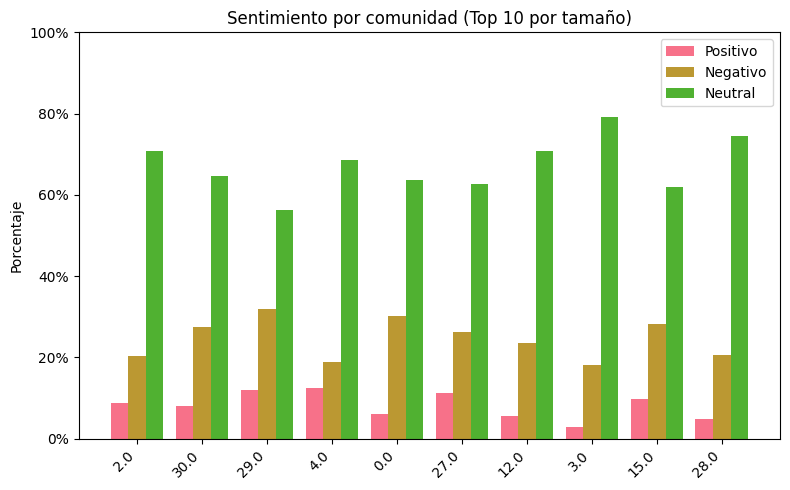

Guardado: sentiment_pct_by_community_top10.png


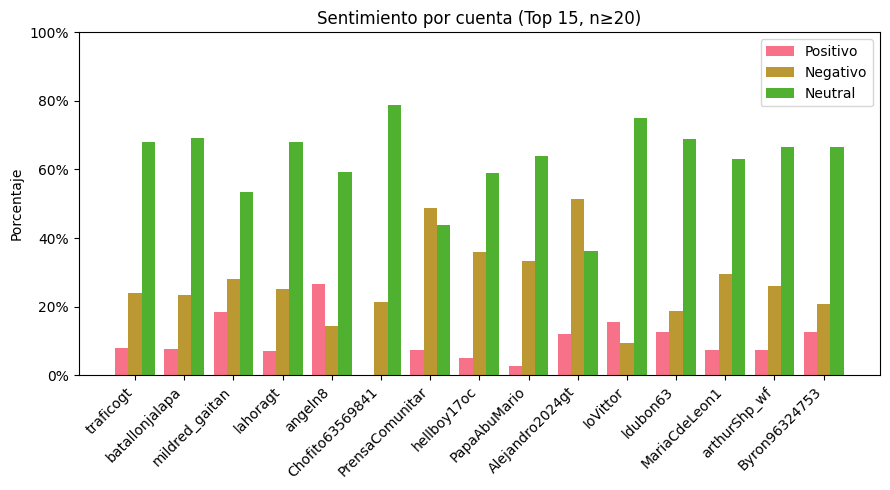

Guardado: sentiment_pct_by_user_top15.png


In [59]:
# %% [markdown]
# Barras: % positivo/negativo/neutral por comunidad y por cuenta
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# ---------- helpers ----------
def ensure_pct_cols(df, pos='n_pos', neg='n_neg', neu='n_neu', total='n_total'):
    """Asegura columnas pct_pos/pct_neg/pct_neu (en 0-1). Si ya existen, las normaliza si vienen en 0-100."""
    have_pct = all(c in df.columns for c in ['pct_pos','pct_neg','pct_neu'])
    if have_pct:
        # si vienen en 0-100, pásalas a 0-1
        for c in ['pct_pos','pct_neg','pct_neu']:
            if df[c].max() > 1.5:
                df[c] = df[c] / 100.0
        return df

    # calcular desde conteos
    # intenta adivinar columnas de total si faltan
    if total not in df.columns:
        cand = [c for c in ['total','count','n','messages','n_messages','n_msgs'] if c in df.columns]
        if cand:
            total = cand[0]
        else:
            # crea total si tenemos pos/neg/neu
            if all(c in df.columns for c in [pos,neg,neu]):
                df[total] = df[pos].fillna(0) + df[neg].fillna(0) + df[neu].fillna(0)
            else:
                # no hay forma de derivarlo; crea pct=NA
                for c in ['pct_pos','pct_neg','pct_neu']:
                    df[c] = np.nan
                return df

    for c in [pos,neg,neu,total]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors='coerce')

    df['pct_pos'] = (df.get(pos,0) / df[total]).replace([np.inf,-np.inf], np.nan)
    df['pct_neg'] = (df.get(neg,0) / df[total]).replace([np.inf,-np.inf], np.nan)
    df['pct_neu'] = (df.get(neu,0) / df[total]).replace([np.inf,-np.inf], np.nan)
    return df

def pick_total_col(df):
    for c in ['n_total','total','count','n','messages','n_messages','n_msgs']:
        if c in df.columns:
            return c
    # fallback: intenta sumar si existen n_pos/n_neg/n_neu
    if all(c in df.columns for c in ['n_pos','n_neg','n_neu']):
        df['n_total'] = df['n_pos'].fillna(0)+df['n_neg'].fillna(0)+df['n_neu'].fillna(0)
        return 'n_total'
    return None

def percent_formatter(x, _pos):
    return f"{x*100:.0f}%"

def plot_grouped_bars(df, id_col, title, outfile):
    """Grafica barras agrupadas para pct_pos/neg/neu."""
    cols = ['pct_pos','pct_neg','pct_neu']
    # descarta filas con NaN en todos los pct
    mask_any = df[cols].notna().any(axis=1)
    dfp = df.loc[mask_any, [id_col]+cols].copy()
    if dfp.empty:
        print(f"[AVISO] No hay datos para graficar: {title}")
        return

    # asegurar orden y tipos
    if id_col == 'community':
        # intenta convertir a int para ordenar bonito
        dfp['community'] = pd.to_numeric(dfp['community'], errors='ignore')
    x = np.arange(len(dfp))
    width = 0.27

    fig, ax = plt.subplots(figsize=(max(8, len(dfp)*0.6), 5))
    bars_pos = ax.bar(x - width, dfp['pct_pos'].fillna(0).values, width, label='Positivo')
    bars_neg = ax.bar(x,          dfp['pct_neg'].fillna(0).values, width, label='Negativo')
    bars_neu = ax.bar(x + width, dfp['pct_neu'].fillna(0).values, width, label='Neutral')

    ax.set_title(title)
    ax.set_ylabel("Porcentaje")
    ax.set_xticks(x)
    ax.set_xticklabels(dfp[id_col].astype(str).tolist(), rotation=45, ha='right')
    ax.yaxis.set_major_formatter(FuncFormatter(percent_formatter))
    ax.set_ylim(0, 1)  # 0–100%

    ax.legend()
    fig.tight_layout()
    plt.show()

    try:
        fig.savefig(outfile, dpi=150, bbox_inches='tight')
        print(f"Guardado: {outfile}")
    except Exception as e:
        print(f"[AVISO] No se pudo guardar {outfile}: {e}")
    plt.close(fig)

# ---------- 1) Por comunidad ----------
path_comm = "sentiment_by_community.csv"
if os.path.exists(path_comm):
    comm = pd.read_csv(path_comm)
    comm = ensure_pct_cols(comm)

    total_col = pick_total_col(comm)
    if total_col is None:
        # si no hay total, usa 'community' para ordenar arbitrariamente
        comm['_sort'] = comm['community']
        total_col = '_sort'

    # Top 10 por tamaño
    comm_top = (comm.sort_values(total_col, ascending=False)
                    .head(10)
                    .copy())
    plot_grouped_bars(
        comm_top,
        id_col='community',
        title="Sentimiento por comunidad (Top 10 por tamaño)",
        outfile="sentiment_pct_by_community_top10.png"
    )
else:
    print(f"[ERROR] No se encontró {path_comm}. Ejecuta primero el 9.1 (sentimiento por comunidad).")

# ---------- 2) Por cuenta/usuario ----------
path_user = "sentiment_by_user.csv"
if os.path.exists(path_user):
    users = pd.read_csv(path_user)
    users = ensure_pct_cols(users)

    total_col = pick_total_col(users)
    if total_col is None:
        # crea total mínimo a partir de pct (no ideal, pero evita bloqueo)
        users['n_total'] = 1.0
        total_col = 'n_total'

    # filtro mínimo de mensajes para robustez
    min_msgs = 20
    users_f = users.loc[users[total_col] >= min_msgs].copy()

    # Top 15 por tamaño
    users_top = (users_f.sort_values(total_col, ascending=False)
                        .head(15)
                        .copy())

    plot_grouped_bars(
        users_top.rename(columns={'user':'account'}),
        id_col='account',
        title=f"Sentimiento por cuenta (Top 15, n≥{min_msgs})",
        outfile="sentiment_pct_by_user_top15.png"
    )
else:
    print(f"[ERROR] No se encontró {path_user}. Ejecuta primero el 9.1 (sentimiento por usuario).")


Al hacer la comparación de sentimientos por comunidad se confirma que en los grupos más grandes el tono que domuna es el *neutral* con un porcentaje de  alrededor del 60%-80%. Lo cual sugiera que la mayoría de los mensajes son informativos o descriptivos, sin carga emocional marcada. EL 20%-30% es de mensajes negativos, mientras que los mensajes positivos conforman alrededor del 10%. Esta distribución es lógica con respecto de redes en tráfico.

Cuando realizamos el sentimiento por cuenta, se observa un patrón simililar. Las cuentas más influyentes como @traficogt, @batallonjallapa, @mildred\_gaitan tienden a generar mensajes neutrales, aunque con un porcentaje consible de mensajes negativos. En algunas cuentas, la cantidad de mensajes negativos aumenta hasta rozar o superar el 50% lo que sugiere que es un tono más crítico. En el caso de cuentas como @PrensaComunitar poseen un contenido netural, lo cual hace sentido por su rol de medio de comunicación



# Análisis de hora y fechas

In [48]:
import os, sys, json, math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- cargar mensajes ---
MSG_FILE = "traficogt_messages.csv"
if 'messages' not in globals() or messages is None or messages.empty:
    assert os.path.exists(MSG_FILE), f"No encuentro {MSG_FILE} en el directorio actual."
    messages = pd.read_csv(MSG_FILE, dtype=str, keep_default_na=False, na_values=[""])
print("Mensajes cargados:", messages.shape, "| columnas:", list(messages.columns)[:10], "...")

# --- parseo de fechas (UTC por defecto) ---
messages['date'] = pd.to_datetime(messages['date'], errors='coerce', utc=True)

# Si quieres ver tiempos en Guatemala (UTC-6), descomenta:
# messages['date_local'] = messages['date'].dt.tz_convert('America/Guatemala')
# base_time = 'date_local'
base_time = 'date'

# --- features de tiempo ---
messages['date_day'] = messages[base_time].dt.floor('D')
messages['hour'] = messages[base_time].dt.hour
messages['dow'] = messages[base_time].dt.dayofweek  # 0=Lunes, 6=Domingo

# Map de nombres de día (ES simple)
dow_map = {0:"Lun",1:"Mar",2:"Mié",3:"Jue",4:"Vie",5:"Sáb",6:"Dom"}
messages['dow_name'] = messages['dow'].map(dow_map)

print(messages[['date', 'date_day','hour','dow','dow_name']].head())


Mensajes cargados: (5604, 32) | columnas: ['id', 'date', 'conversationId', 'inReplyToTweetId', 'inReplyToUser', 'user', 'user_id', 'rawContent', 'lang', 'hashtags'] ...
                       date                  date_day  hour  dow dow_name
0 2024-09-12 14:22:06+00:00 2024-09-12 00:00:00+00:00    14    3      Jue
1 2024-09-12 00:39:56+00:00 2024-09-12 00:00:00+00:00     0    3      Jue
2 2024-09-12 01:21:04+00:00 2024-09-12 00:00:00+00:00     1    3      Jue
3 2024-09-11 20:20:01+00:00 2024-09-11 00:00:00+00:00    20    2      Mié
4 2024-09-11 00:34:31+00:00 2024-09-11 00:00:00+00:00     0    2      Mié


Serie diaria guardada en: ts_tweets_per_day.csv


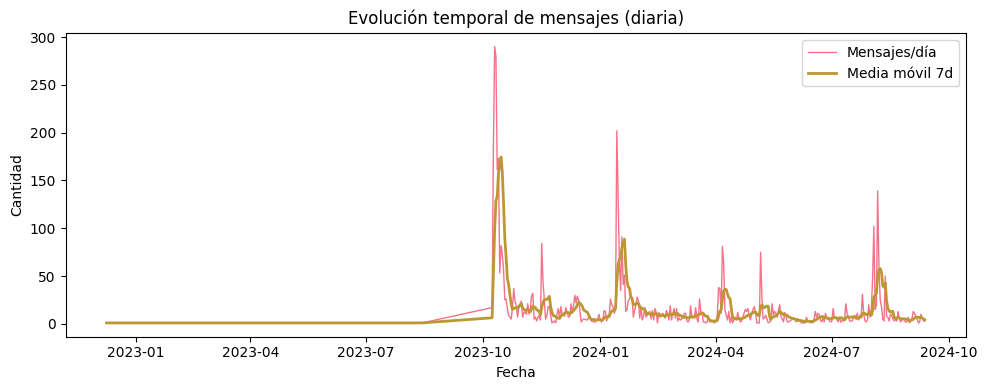

Gráfico guardado en: plot_tweets_per_day.png


In [49]:
# Conteo por día
ts_daily = messages.groupby('date_day', as_index=False).size().rename(columns={'size':'n_msgs'})
ts_daily['n_msgs_ma7'] = ts_daily['n_msgs'].rolling(7, min_periods=1).mean()

# Guardados
ts_daily.to_csv("ts_tweets_per_day.csv", index=False, encoding="utf-8")
print("Serie diaria guardada en: ts_tweets_per_day.csv")

# Plot
plt.figure(figsize=(10,4))
plt.plot(ts_daily['date_day'], ts_daily['n_msgs'], label='Mensajes/día', linewidth=1)
plt.plot(ts_daily['date_day'], ts_daily['n_msgs_ma7'], label='Media móvil 7d', linewidth=2)
plt.title("Evolución temporal de mensajes (diaria)")
plt.xlabel("Fecha"); plt.ylabel("Cantidad")
plt.legend(); plt.tight_layout()
plt.savefig("plot_tweets_per_day.png", dpi=150)
plt.show()
print("Gráfico guardado en: plot_tweets_per_day.png")


En la línea temporal se puede observar un patrón irregular, en donde hay períodos de baja actividad y otros picos marcados en ciertas fechas. Los mayores picos aparecen a finales de 2023 e incisos del 2024, en donde los mensajes llegan a superar los 200 en alún punto. Seguidmaente se disminuye la actividad, aunque  existen  repuntes importantes en los meses de abril y julio.
El tráfico de mensajes no es constante sino altamente reactivo a sucesos específicos que concentran la atención y disparan la interacción en la red.


Tabla heatmap guardada en: heatmap_dow_hour_counts.csv


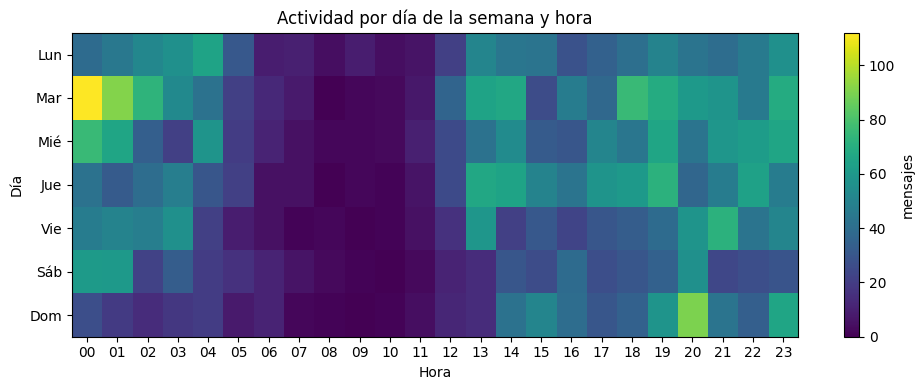

Gráfico guardado en: heatmap_dow_hour.png


In [50]:
# Tabla hora x día
pivot_hd = (messages
            .groupby(['dow','hour'], as_index=False)
            .size()
            .pivot(index='dow', columns='hour', values='size')
            .fillna(0).reindex(index=range(7), columns=range(24)))

# Guardar tabla
pivot_hd.to_csv("heatmap_dow_hour_counts.csv", encoding="utf-8")
print("Tabla heatmap guardada en: heatmap_dow_hour_counts.csv")

# Heatmap simple con matplotlib
plt.figure(figsize=(10,4))
plt.imshow(pivot_hd.values, aspect='auto', interpolation='nearest')
plt.colorbar(label="mensajes")
plt.yticks(ticks=range(7), labels=[{0:"Lun",1:"Mar",2:"Mié",3:"Jue",4:"Vie",5:"Sáb",6:"Dom"}[i] for i in range(7)])
plt.xticks(ticks=range(24), labels=[f"{h:02d}" for h in range(24)], rotation=0)
plt.title("Actividad por día de la semana y hora")
plt.xlabel("Hora"); plt.ylabel("Día")
plt.tight_layout()
plt.savefig("heatmap_dow_hour.png", dpi=150)
plt.show()
print("Gráfico guardado en: heatmap_dow_hour.png")


En el heatmap se observa que la mayor concentración de mensajes está acumulada en las madurgadas de los martes, entre las 00:00 y 03:00 horas, donde los mensajes llegan a superar los 100 en una sola hora. También los miércoles y lunes en horarios simialres, lo que podría inddicar que los incidentes nocturnos o de inicio de semana generan un volumen considerable de interacción. 

Durante las mañanas (07:00 a 10:00) la actividad disminuye notablemente manteniéndose en niveles bajos hasta el mediodía. Sin embargo, se aprecia un repunte constante entre las tardes y noches (18:00 a 22:00), especialmente los fines de semana, donde el tráfico y la movilidad urbana suelen ser más intensos.


Mapa user→community: (2743, 2) ejemplo: [{'user': '01lu88', 'community': 0}, {'user': 'barevalodeleon', 'community': 0}, {'user': 'emisorasunidas', 'community': 1}]
Serie por comunidad (top3) -> ts_tweets_per_day_by_community_top3.csv
Top 3 comunidades: [0.0, 6.0, 8.0]


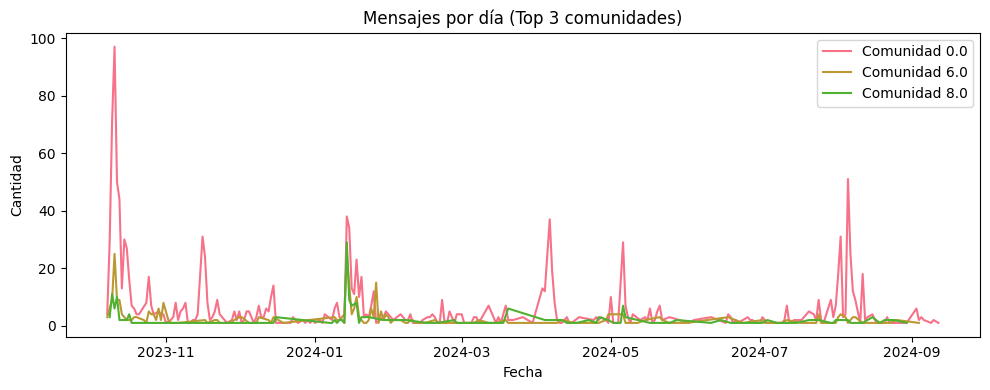

Gráfico guardado en: plot_tweets_per_day_top3_communities.png


In [51]:
import networkx as nx

# 1) Intentar recuperar mapeo ya existente en variables previas
df_map = None
if 'df_nodes' in globals() and isinstance(df_nodes, pd.DataFrame) and {'user','community'}.issubset(df_nodes.columns):
    df_map = df_nodes.loc[:, ['user','community']].copy()

# 2) Si no existe, intentar desde partición previa 'part'
if df_map is None and 'part' in globals() and isinstance(part, dict):
    df_map = pd.DataFrame(list(part.items()), columns=['user','community'])

# 3) Si aún no, reconstruir desde interacciones
if df_map is None:
    INTER_FILE = "traficogt_interactions_clean.csv"
    assert os.path.exists(INTER_FILE), "No encuentro traficot_interactions_clean.csv para reconstruir comunidades."
    df_inter = pd.read_csv(INTER_FILE, dtype=str, keep_default_na=False, na_values=[""])
    # construir grafo no dirigido con peso
    w = df_inter.groupby(['source_user','target_user'])['interaction_type'].count().reset_index(name='weight')
    G_u_tmp = nx.Graph()
    for _,r in w.iterrows():
        if r['source_user'] and r['target_user']:
            G_u_tmp.add_edge(r['source_user'], r['target_user'], weight=int(r['weight']))
    # particionar
    try:
        import community as community_louvain
        part_tmp = community_louvain.best_partition(G_u_tmp)
        df_map = pd.DataFrame(list(part_tmp.items()), columns=['user','community'])
    except Exception:
        comms = nx.algorithms.community.greedy_modularity_communities(G_u_tmp, weight='weight')
        rows = []
        for cid, cset in enumerate(comms):
            for u in cset:
                rows.append((u, cid))
        df_map = pd.DataFrame(rows, columns=['user','community'])

print("Mapa user→community:", df_map.shape, "ejemplo:", df_map.head(3).to_dict('records'))

# Unir con mensajes
assert 'user' in messages.columns, "La tabla messages debe tener columna 'user'."
msg_comm = messages.merge(df_map, how='left', on='user')

# Elegir top 3 comunidades por volumen de mensajes
top_comms = (msg_comm['community']
             .value_counts()
             .dropna()
             .head(3)
             .index.tolist())

msg_comm_top = msg_comm[msg_comm['community'].isin(top_comms)].copy()

# Serie diaria por comunidad
ts_comm = (msg_comm_top
           .groupby(['community','date_day'], as_index=False)
           .size()
           .rename(columns={'size':'n_msgs'}))

ts_comm.to_csv("ts_tweets_per_day_by_community_top3.csv", index=False, encoding="utf-8")
print("Serie por comunidad (top3) -> ts_tweets_per_day_by_community_top3.csv")
print("Top 3 comunidades:", top_comms)

# Plot líneas
plt.figure(figsize=(10,4))
for com in top_comms:
    sub = ts_comm[ts_comm['community']==com]
    plt.plot(sub['date_day'], sub['n_msgs'], label=f"Comunidad {com}")
plt.title("Mensajes por día (Top 3 comunidades)")
plt.xlabel("Fecha"); plt.ylabel("Cantidad")
plt.legend(); plt.tight_layout()
plt.savefig("plot_tweets_per_day_top3_communities.png", dpi=150)
plt.show()
print("Gráfico guardado en: plot_tweets_per_day_top3_communities.png")


Esta gráfica se observa la evolución temporal de los mensajes en las tres comunidades más activas.

La Comunidad 0 es la más dinámica, ya que concentra la mayor parte de los picos de actividad llegando a días en  que supera los 90 mensajes. 

Las Comunidades 6 y 8 presentan un volumen mucho más estable y bajo, raramente superando los 10 mensajes diarios. Sus curvas muestran oscilaciones modestas y en algunos momentos acompañan los picos de la Comunidad 0, pero nunca con la misma intensidad. 



# Contextualización

Los hallazgos indican una red enfocada en unas pocas cuentas con gran relevancia estructural que operan como centros informativos, mientras que otros nodos con alta intermediación sirven como enlaces entre comunidades. En cuanto a la formación de la opinión pública, ese papel es fundamental: los hubs establecen la agenda y amplifican datos al tiempo que los puentes permiten la circulación entre burbujas temáticas, posibilitando que un tema transite de un nicho a una esfera pública más amplia. Cuando los hubs y los puentes coinciden en contenido o en enfoque, el impacto en la percepción pública se potencia; si presentan diferencias, la comunicación tiende a dividirse y polarizarse.

Las comunidades identificadas muestran tanto grupos temáticos como microgrupos cerrados con gran aislamiento. Las comunidades amplias y poco aisladas funcionan como foros públicos deliberativos donde la información fluye hacia y desde otras comunidades; las comunidades con un alto nivel de aislamiento operan como cámaras de eco o nichos específicos donde se consolidan narrativas locales. Esto implica que las campañas informativas o eventos puntuales (accidentes, escándalos, decisiones políticas) hallan en la comunidad 0 —y en hubs afines— la forma más veloz de llegar a una gran audiencia, mientras que las microcomunidades pueden intensificar mensajes concretos con menor repercusión externa.

El análisis temporal y de sentimiento ofrece una perspectiva adicional: la actividad responde de manera muy reactiva a eventos específicos y mayoritariamente exhibe un tono neutral/informativo, aunque hay áreas significativas de negatividad en ciertas comunidades. En la práctica, esto significa que la opinión pública se organiza en dos niveles: un nivel informativo amplio y otro nivel crítico o de juicio que alberga el debate normativo y valorativo. Si los actores principales establecen un marco interpretativo, destacando corrupción o crisis—, las comunidades intermedias y las secundarias lo replicarán, ajustando el sentimiento general.

